In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from pathlib import Path
import seaborn as sns
import itables as ishow
from itables import options
from sklearn.metrics import roc_auc_score
import os



In [154]:
# Notebooks setup
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=False)
options.warn_on_undocumented_option = False  # Silence warnings

from itables import options
options.lengthMenu = [10, 50, 150]
options.maxBytes = 0
options.maxColumns = 50
options.maxRows = 150
options.paging = True
options.searching = True
options.ordering = True
options.scrollX = True
options.scrollY = "400px"
options.scrollCollapse = True
options.classes = "display compact"
options.style = "width:100%"

import pandas as pd
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)

# Feature Engineering - Stage 1
The goal of the feature engineering notebook is to create a feature set that we ultimetly plug into our model.

I aim to build two feature sets - one for logistic regression and one for the XGBoost model.

The logistic regression model will be used with 'linear friendly' features, typically smaller feature sets and categories with less cardinality. We also need to pay more attention to scaling and normalisation and explicitly take care of missing values.

The XGBoost model we can more freely throw features at and let it uncover the non-linear relationships, especially with categorical features.



For both feature sets, I would like to capture the following details:
- Customer's demographic profile
- Details of the applicant's home
- Their credit behavior
- Their credit profile


In [155]:
# Helpers
def load_dataset(filename):
    """Load a CSV file from the data directory"""
    data_path = Path() / filename
    print(f"Loading {filename}...")
    df = pd.read_csv(data_path)
    print(f"✓ Loaded {filename}: {df.shape[0]:,} rows × {df.shape[1]} columns\n")
    return df

###################
# Split Data
###################

def split_applications_simple(
    df,
    id_col="SK_ID_CURR",
    target_col="TARGET",
    test_size=0.20,
    val_size=0.10,
    random_state=42,
    stratify=True,
    save_path="split_ids.csv",
):
    # Train+Val vs Test
    stratify_vec = df[target_col] if stratify else None
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        random_state=random_state,
        stratify=stratify_vec
    )

    # Train vs Val (val_size is on train_val)
    val_fraction_of_train_val = val_size / (1.0 - test_size)
    stratify_vec_2 = train_val_df[target_col] if stratify else None
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_fraction_of_train_val,
        random_state=random_state,
        stratify=stratify_vec_2
    )

    # Save split IDs so that we canuse them later for other datasets and testing pipeline
    split_map_df = pd.concat(
        [
            pd.DataFrame({id_col: train_df[id_col].values, "split": "train"}),
            pd.DataFrame({id_col: val_df[id_col].values, "split": "val"}),
            pd.DataFrame({id_col: test_df[id_col].values, "split": "test"}),
        ],
        ignore_index=True
    )

    if save_path:
        os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)
        split_map_df.to_csv(save_path, index=False)

    return train_df, val_df, test_df, split_map_df


def split_by_ids(df, split_ids_df, id_col="SK_ID_CURR"):
    df_with_split = df.merge(split_ids_df, on=id_col, how="inner")
    train = df_with_split[df_with_split["split"] == "train"].drop(columns=["split"])
    val   = df_with_split[df_with_split["split"] == "val"].drop(columns=["split"])
    test  = df_with_split[df_with_split["split"] == "test"].drop(columns=["split"])
    return train, val, test







# Import Data

In [156]:
applications = load_dataset('../data/raw_data/applications.csv')
applications.head()
selected_columns = [
"SK_ID_CURR",
    "TARGET",
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
    "NAME_CONTRACT_TYPE",
    "CODE_GENDER",
    "CNT_CHILDREN",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
    "DAYS_REGISTRATION",
    "DAYS_ID_PUBLISH",
    "DAYS_LAST_PHONE_CHANGE",
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "REGION_RATING_CLIENT",
    "REGION_POPULATION_RELATIVE",
    "REGION_RATING_CLIENT_W_CITY",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "AMT_REQ_CREDIT_BUREAU_MON",
    "OWN_CAR_AGE",
    "FLAG_OWN_CAR",
]

# Create filtered dataframe
apps_df = applications[selected_columns].copy()

bureau = load_dataset('../data/raw_data/bureau.csv')

bureau_cols = [
    "SK_ID_CURR",
    "CREDIT_ACTIVE",
    "DAYS_CREDIT",
    "DAYS_CREDIT_UPDATE",
    "CREDIT_DAY_OVERDUE",
    "DAYS_CREDIT_ENDDATE",
    "AMT_CREDIT_MAX_OVERDUE",
    "CNT_CREDIT_PROLONG",
    "AMT_CREDIT_SUM",
    "AMT_CREDIT_SUM_DEBT",
    "AMT_CREDIT_SUM_LIMIT",
]
bureau_df = bureau[bureau_cols].copy()

credit_card_balance = load_dataset('../data/raw_data/credit_card_balance.csv')

credit_card_cols = [
    "SK_ID_PREV",
    "SK_ID_CURR",
    "MONTHS_BALANCE",
    "AMT_BALANCE",
    "AMT_CREDIT_LIMIT_ACTUAL",
    "AMT_PAYMENT_TOTAL_CURRENT",
    "AMT_RECIVABLE",
    "AMT_INST_MIN_REGULARITY",
    "CNT_INSTALMENT_MATURE_CUM",
    "NAME_CONTRACT_STATUS",
    "SK_DPD_DEF",
]

credit_card_df = credit_card_balance[credit_card_cols].copy()



pos_cash = load_dataset('../data/raw_data/pos_cash_balance.csv')

pos_cash_cols = [
    "SK_ID_PREV",
    "SK_ID_CURR",
    "CNT_INSTALMENT_FUTURE",
    "CNT_INSTALMENT",
    "MONTHS_BALANCE",
    "NAME_CONTRACT_STATUS",
    "SK_DPD",
    "SK_DPD_DEF",
]

pos_cash_df = pos_cash[pos_cash_cols].copy()


previous_applications = load_dataset('../data/raw_data/previous_applications.csv')

previous_app_cols = [
"SK_ID_PREV",
    "SK_ID_CURR",
    "NAME_CONTRACT_TYPE",
    "AMT_APPLICATION",
    "AMT_CREDIT",
    "DAYS_LAST_DUE",
    "DAYS_TERMINATION",
    "AMT_ANNUITY",
    "CNT_PAYMENT",
    "CODE_REJECT_REASON",
    "DAYS_DECISION",
    "RATE_INTEREST_PRIMARY",
    "AMT_GOODS_PRICE",
    "AMT_DOWN_PAYMENT",
    "PRODUCT_COMBINATION",
]


previous_app_df = previous_applications[previous_app_cols].copy()


# installments = load_dataset('installments.csv')
# bureau_balance = load_dataset('bureau_balance.csv')


Loading ../data/raw_data/applications.csv...
✓ Loaded ../data/raw_data/applications.csv: 20,000 rows × 122 columns

Loading ../data/raw_data/bureau.csv...
✓ Loaded ../data/raw_data/bureau.csv: 94,490 rows × 17 columns

Loading ../data/raw_data/credit_card_balance.csv...
✓ Loaded ../data/raw_data/credit_card_balance.csv: 155,840 rows × 24 columns

Loading ../data/raw_data/pos_cash_balance.csv...
✓ Loaded ../data/raw_data/pos_cash_balance.csv: 530,654 rows × 9 columns

Loading ../data/raw_data/previous_applications.csv...
✓ Loaded ../data/raw_data/previous_applications.csv: 90,943 rows × 37 columns



# Split Data

I am splitting data before any preprocessing to ensure that we do not leak any information from the validation or test sets into the training set.
I will split into 70% training, 10% validation and 20% test.
I am also using stratified sampling to ensure that we have the same proportions of target variables in the different sets.

In [157]:
apps_train_df, apps_val_df, apps_test_df, split_ids_df = split_applications_simple(
    apps_df,
    test_size=0.20,
    val_size=0.10,
    random_state=42,
    stratify=True,
    save_path="split_ids.csv",
)

previous_app_train_df, previous_app_val_df, previous_app_test_df = split_by_ids(previous_app_df, split_ids_df)
pos_cash_train_df, pos_cash_val_df, pos_cash_test_df = split_by_ids(pos_cash_df, split_ids_df)
credit_card_train_df, credit_card_val_df, credit_card_test_df = split_by_ids(credit_card_df, split_ids_df)
bureau_train_df, bureau_val_df, bureau_test_df = split_by_ids(bureau_df, split_ids_df)



# Clean Data

## Enforce Dtypes
1. ensure we are using the same dtypes for all datasets


In [158]:
# DType enforcements - floats, objects, ints, bools - base on Training set


def fit_category_maps(train_df: pd.DataFrame, cat_cols: list[str]) -> dict[str, list]:
    """
    Learn category levels from TRAIN only (so val/test are coerced to same categories).
    """
    cat_maps = {}
    for c in cat_cols:
        if c in train_df.columns:
            # Dropna so NaN remains NaN (not a literal category)
            cat_maps[c] = sorted(train_df[c].dropna().unique().tolist())
    return cat_maps


def enforce_dtypes(
    df: pd.DataFrame,
    numeric_cols: list[str],
    int_cols: list[str],
    cat_cols: list[str],
    cat_maps: dict[str, list] | None = None,
) -> pd.DataFrame:
    """
    Enforce dtypes in a reproducible way across splits.
    - numeric_cols -> float32
    - int_cols     -> pandas nullable Int64 (safe with NaNs)
    - cat_cols     -> category, with train-fitted levels if cat_maps provided
    """
    out = df.copy()

    # Numeric (float)
    for c in numeric_cols:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce").astype("float32")

    # Integer (nullable)
    for c in int_cols:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce").astype("Int64")

    # Categoricals
    for c in cat_cols:
        if c in out.columns:
            if cat_maps is not None and c in cat_maps:
                out[c] = out[c].astype(pd.CategoricalDtype(categories=cat_maps[c]))
            else:
                out[c] = out[c].astype("category")

    return out





## Select inital columns
I manually selected the columns I want to keep from the datasets. These are manually selected based on my knowledge of the datasets and my experience after my EDA.

I will later do more feature selection based on the correlation matrix and the feature importance of the models.

In [159]:
#Dataset-specific schemas
#############

# Applications
APP_CAT_COLS = [
    "NAME_CONTRACT_TYPE",
    "CODE_GENDER",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "FLAG_OWN_CAR",
]
APP_INT_COLS = [
    "SK_ID_CURR",
    "TARGET",
    "CNT_CHILDREN",
]
APP_NUM_COLS = [
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
    "DAYS_REGISTRATION",
    "DAYS_ID_PUBLISH",
    "DAYS_LAST_PHONE_CHANGE",
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "REGION_RATING_CLIENT",
    "REGION_POPULATION_RELATIVE",
    "REGION_RATING_CLIENT_W_CITY",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "AMT_REQ_CREDIT_BUREAU_MON",
    "OWN_CAR_AGE",
]

# Previous applications
PREV_CAT_COLS = [
    "NAME_CONTRACT_TYPE",
    "CODE_REJECT_REASON",
    # PRODUCT_COMBINATION intentionally excluded by you
]
PREV_INT_COLS = [
    "SK_ID_PREV",
    "SK_ID_CURR",
]
PREV_NUM_COLS = [
    "AMT_APPLICATION",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "CNT_PAYMENT",
    "DAYS_DECISION",
    "DAYS_LAST_DUE",
    "DAYS_TERMINATION",
    "RATE_INTEREST_PRIMARY",
    "AMT_GOODS_PRICE",
    "AMT_DOWN_PAYMENT",
]

# POS Cash Balance
POS_CAT_COLS = ["NAME_CONTRACT_STATUS"]
POS_INT_COLS = ["SK_ID_PREV", "SK_ID_CURR", "MONTHS_BALANCE"]
POS_NUM_COLS = ["SK_DPD_DEF"]  # you are ignoring SK_DPD

# Credit Card Balance
CC_CAT_COLS = ["NAME_CONTRACT_STATUS"]
CC_INT_COLS = ["SK_ID_PREV", "SK_ID_CURR", "MONTHS_BALANCE"]
CC_NUM_COLS = [
    "AMT_BALANCE",
    "AMT_CREDIT_LIMIT_ACTUAL",
    "AMT_PAYMENT_TOTAL_CURRENT",
    "AMT_RECIVABLE",
    "AMT_INST_MIN_REGULARITY",
    "CNT_INSTALMENT_MATURE_CUM",
    "SK_DPD_DEF",
]

# Bureau
BUREAU_CAT_COLS = ["CREDIT_ACTIVE"]
BUREAU_INT_COLS = ["SK_ID_CURR"]
BUREAU_NUM_COLS = [
    "DAYS_CREDIT",
    "DAYS_CREDIT_UPDATE",
    "CREDIT_DAY_OVERDUE",
    "DAYS_CREDIT_ENDDATE",
    "AMT_CREDIT_MAX_OVERDUE",
    "CNT_CREDIT_PROLONG",
    "AMT_CREDIT_SUM",
    "AMT_CREDIT_SUM_DEBT",
    "AMT_CREDIT_SUM_LIMIT",
]

ALL_COLS = APP_CAT_COLS + APP_INT_COLS + APP_NUM_COLS + PREV_CAT_COLS + PREV_INT_COLS + PREV_NUM_COLS + POS_CAT_COLS + POS_INT_COLS + POS_NUM_COLS + CC_CAT_COLS + CC_INT_COLS + CC_NUM_COLS + BUREAU_CAT_COLS + BUREAU_INT_COLS + BUREAU_NUM_COLS

In [160]:

##############
#Fit category maps on TRAIN only
##############

# Applications
app_cat_maps = fit_category_maps(apps_train_df, APP_CAT_COLS)
# Previous applications
prev_cat_maps = fit_category_maps(previous_app_train_df, PREV_CAT_COLS)
# POS
pos_cat_maps = fit_category_maps(pos_cash_train_df, POS_CAT_COLS)
# Credit cards
cc_cat_maps = fit_category_maps(credit_card_train_df, CC_CAT_COLS)
# Bureau
bureau_cat_maps = fit_category_maps(bureau_train_df, BUREAU_CAT_COLS)


##############
#Apply dtype enforcement per split, per dataset
##############

# Applications
apps_train_df = enforce_dtypes(apps_train_df, APP_NUM_COLS, APP_INT_COLS, APP_CAT_COLS, app_cat_maps)
apps_val_df   = enforce_dtypes(apps_val_df,   APP_NUM_COLS, APP_INT_COLS, APP_CAT_COLS, app_cat_maps)
apps_test_df  = enforce_dtypes(apps_test_df,  APP_NUM_COLS, APP_INT_COLS, APP_CAT_COLS, app_cat_maps)

# Previous applications
previous_app_train_df = enforce_dtypes(previous_app_train_df, PREV_NUM_COLS, PREV_INT_COLS, PREV_CAT_COLS, prev_cat_maps)
previous_app_val_df   = enforce_dtypes(previous_app_val_df,   PREV_NUM_COLS, PREV_INT_COLS, PREV_CAT_COLS, prev_cat_maps)
previous_app_test_df  = enforce_dtypes(previous_app_test_df,  PREV_NUM_COLS, PREV_INT_COLS, PREV_CAT_COLS, prev_cat_maps)

# POS cash
pos_cash_train_df = enforce_dtypes(pos_cash_train_df, POS_NUM_COLS, POS_INT_COLS, POS_CAT_COLS, pos_cat_maps)
pos_cash_val_df   = enforce_dtypes(pos_cash_val_df,   POS_NUM_COLS, POS_INT_COLS, POS_CAT_COLS, pos_cat_maps)
pos_cash_test_df  = enforce_dtypes(pos_cash_test_df,  POS_NUM_COLS, POS_INT_COLS, POS_CAT_COLS, pos_cat_maps)

# Credit cards
credit_card_train_df = enforce_dtypes(credit_card_train_df, CC_NUM_COLS, CC_INT_COLS, CC_CAT_COLS, cc_cat_maps)
credit_card_val_df   = enforce_dtypes(credit_card_val_df,   CC_NUM_COLS, CC_INT_COLS, CC_CAT_COLS, cc_cat_maps)
credit_card_test_df  = enforce_dtypes(credit_card_test_df,  CC_NUM_COLS, CC_INT_COLS, CC_CAT_COLS, cc_cat_maps)

# Bureau
bureau_train_df = enforce_dtypes(bureau_train_df, BUREAU_NUM_COLS, BUREAU_INT_COLS, BUREAU_CAT_COLS, bureau_cat_maps)
bureau_val_df   = enforce_dtypes(bureau_val_df,   BUREAU_NUM_COLS, BUREAU_INT_COLS, BUREAU_CAT_COLS, bureau_cat_maps)
bureau_test_df  = enforce_dtypes(bureau_test_df,  BUREAU_NUM_COLS, BUREAU_INT_COLS, BUREAU_CAT_COLS, bureau_cat_maps)



## Cleaning Helper Functions

## Imputation


### Train-Only Feature Fitting and Recency-Based Aggregations
1. Train-only fitting: All imputation values, thresholds, and window definitions are computed on the TRAIN split only, then reused unchanged on validation/test to avoid leakage.
2. External sources (EXT_SOURCE_1–3): Create a single feature EXT_SOURCE_SCORE as the row-wise mean of EXT_SOURCE_1..3 (skipping NaNs). If all three are missing, EXT_SOURCE_SCORE remains NaN and is imputed using the TRAIN median of EXT_SOURCE_SCORE.
3. Bureau features: Use DAYS_CREDIT to define a recency window (Home Credit convention: DAYS_* are negative for past events) and aggregate bureau signals within that window.

4. POS_CASH and credit card balance: For each table, define a recency window and a configurable list of statuses that count as “active”, then compute aggregated history features using those definitions (with parameters fit on TRAIN only).

In [161]:
# Params functions


def fit_applications_imputation_params(apps_train_df: pd.DataFrame) -> dict:

    params: dict = {}

    params["obs_30_median"] = float(apps_train_df["OBS_30_CNT_SOCIAL_CIRCLE"].median())
    params["amt_annuity_median"] = float(apps_train_df["AMT_ANNUITY"].median())
    params["amt_goods_price_global_median"] = float(apps_train_df["AMT_GOODS_PRICE"].median())

  
    ext_cols = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]

    # ext_score_train = apps_train_df[ext_cols].mean(axis=1, skipna=True)
    ext_score_train = apps_train_df[ext_cols].mean(axis=1, skipna=True)

    # Median of the combined score over rows where at least one source exists
    params["ext_score_median"] = float(ext_score_train.dropna().median())

    # AMT_GOODS_PRICE: group median by contract type, fallback to global
    # Add observed=False to silence pandas warning & keep current behavior.
    by_ct = apps_train_df.groupby("NAME_CONTRACT_TYPE", observed=False)["AMT_GOODS_PRICE"].median()
    params["amt_goods_price_by_contract_type"] = {str(k): float(v) for k, v in by_ct.items()}

    # AMT_REQ_CREDIT_BUREAU_MON fill value (paired with missing flag)
    params["amt_req_credit_bureau_mon_fill"] = 0.0

    return params



def fit_previous_applications_imputation_params(prev_train_df: pd.DataFrame) -> dict:
    params = {}
    params["amt_goods_price_global_median"] = prev_train_df["AMT_GOODS_PRICE"].median()

    # by_ct = prev_train_df.groupby("NAME_CONTRACT_TYPE")["AMT_GOODS_PRICE_MEAN"].median()
    by_ct = prev_train_df.groupby("NAME_CONTRACT_TYPE")["AMT_GOODS_PRICE"].median()
    params["amt_goods_price_by_contract_type"] = {str(k): float(v) for k, v in by_ct.items()}

    params["amt_annuity_median"] = prev_train_df["AMT_ANNUITY"].median()
    params["amt_down_payment_median"] = prev_train_df["AMT_DOWN_PAYMENT"].median()
    return params



def fit_bureau_params(bureau_train_df: pd.DataFrame, window_months: int = 6) -> dict:

    params = {}
    params["window_months"] = window_months
    params["window_days"] = int(window_months * 30)

    params["active_labels"] = ["Active"]

    # Caps to reduce tail risk (fit cap from train quantiles if you want).
    # Keep it simple: fixed conservative caps.
    params["overdue_amt_cap"] = 1_000_000  # adjust later if needed
    params["sum_overdue_days_cap"] = 3650  # cap CREDIT_DAY_OVERDUE at ~10 years

    return params


def fit_pos_cash_params(pos_train_df: pd.DataFrame, window_months: int = 6) -> dict:

    params = {}
    params["window_months"] = window_months

    # Adjust if your dataset uses different labels.
    params["active_statuses"] = ["Active"]

    return params


def fit_credit_card_params(cc_train_df: pd.DataFrame, window_months: int = 6) -> dict:

    params = {}
    params["window_months"] = window_months
    params["active_statuses"] = ["Active"]  # adjust if your dataset uses different labels
    return params




    

### Train-Fitted Missing Handling and Minimal Table Cleaning

1. **Apply TRAIN-fitted imputation to any split (train/val/test)**
   - Create `EXT_SOURCE_SCORE` as the row-wise mean of `EXT_SOURCE_1..3` using available values
   - If all 3 are missing, fill `EXT_SOURCE_SCORE` with the TRAIN median (`params["ext_score_median"]`)
   - Keep `EXT_SOURCES_ALL_MISSING` as the indicator for the “all missing” case

2. **General missing handling philosophy (applied consistently across splits)**
   - Keep raw fields and add missing flags for structurally-missing variables
   - Create `*_FILLED` variants for numeric columns where `0` is a reasonable “not applicable / no activity” default
   - Avoid heavy feature engineering before aggregating to `SK_ID_CURR`

3. **Bureau minimal cleaning and filtering**
   - Keep only recent bureau credits using `DAYS_CREDIT` within the last `N` months (`DAYS_CREDIT >= -window_days`)
   - Create missing flags and `*_FILLED` variants for high-missing numeric fields
   - Coerce numeric columns to numeric types

4. **POS_CASH minimal cleaning and filtering**
   - Drop `CNT_INSTALMENT` and `CNT_INSTALMENT_FUTURE` (per decision)
   - Keep only the last `N` months (`MONTHS_BALANCE` in `[-N, 0]`)
   - Ensure `SK_DPD_DEF` is numeric and fill missing values with `0`

5. **credit_card_balance minimal cleaning and filtering**
   - Keep only the last `N` months (`MONTHS_BALANCE` in `[-N, 0]`)
   - Coerce key numeric fields to numeric
   - Convert structural nulls in `AMT_INST_MIN_REGULARITY` and `CNT_INSTALMENT_MATURE_CUM` to `0`
   - Fill missing behavioural numeric fields with `0` where `0` indicates “no activity” months


In [162]:
# Actual Imputation Function



def apply_applications_imputation(apps_df: pd.DataFrame, params: dict) -> pd.DataFrame:

    df = apps_df.copy()

    ext_cols = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]

    # Flag rows where ALL three are missing (your ~11 rows case)
    all_ext_null = df[ext_cols].isna().all(axis=1)
    df["EXT_SOURCES_ALL_MISSING"] = all_ext_null.astype(int)

    # Combined score: mean across available sources; NaN only when all are missing
    df["EXT_SOURCE_SCORE"] = df[ext_cols].mean(axis=1, skipna=True)

    # Impute ONLY the all-missing rows using the TRAIN median of the combined score
    df.loc[all_ext_null, "EXT_SOURCE_SCORE"] = params["ext_score_median"]

    # Optional (recommended): how many sources were available (0..3)
    df["EXT_SOURCES_N_PRESENT"] = df[ext_cols].notna().sum(axis=1).astype("int8")

    # If you want a simple missing flag for the score itself (should be 0 everywhere after fill)
    df["EXT_SOURCE_SCORE_MISSING"] = df["EXT_SOURCE_SCORE"].isna().astype(int)


    df["AMT_REQ_CREDIT_BUREAU_MON_MISSING"] = df["AMT_REQ_CREDIT_BUREAU_MON"].isna().astype(int)
    df["AMT_REQ_CREDIT_BUREAU_MON_FILLED"] = df["AMT_REQ_CREDIT_BUREAU_MON"].fillna(
        params["amt_req_credit_bureau_mon_fill"]
    )


    df["OBS_30_CNT_SOCIAL_CIRCLE_MISSING"] = df["OBS_30_CNT_SOCIAL_CIRCLE"].isna().astype(int)
    df["OBS_30_CNT_SOCIAL_CIRCLE"] = df["OBS_30_CNT_SOCIAL_CIRCLE"].fillna(params["obs_30_median"])


    df["AMT_GOODS_PRICE_MISSING"] = df["AMT_GOODS_PRICE"].isna().astype(int)

    mask = df["AMT_GOODS_PRICE"].isna()
    if mask.any():
        ct_as_str = df["NAME_CONTRACT_TYPE"].astype("object").astype(str)
        ct_median = ct_as_str.map(params["amt_goods_price_by_contract_type"])

        df.loc[mask, "AMT_GOODS_PRICE"] = ct_median.loc[mask]
        df["AMT_GOODS_PRICE"] = df["AMT_GOODS_PRICE"].fillna(params["amt_goods_price_global_median"])

    df["AMT_ANNUITY_MISSING"] = df["AMT_ANNUITY"].isna().astype(int)
    df["AMT_ANNUITY"] = df["AMT_ANNUITY"].fillna(params["amt_annuity_median"])


    df["HAS_CAR"] = (df["FLAG_OWN_CAR"] == "Y").astype(int)
    df["OWN_CAR_AGE_FOR_MODEL"] = (df["OWN_CAR_AGE"].fillna(0) + 1) * df["HAS_CAR"]
    df["OWN_CAR_AGE_MISSING"] = df["OWN_CAR_AGE"].isna().astype(int)

    return df




def apply_previous_applications_imputation(prev_df: pd.DataFrame, params: dict) -> pd.DataFrame:

    df = prev_df.copy()


    for c in ["DAYS_LAST_DUE", "DAYS_TERMINATION"]:
        if c in df.columns:
            df[f"{c}_MISSING"] = df[c].isna().astype(int)


    if "AMT_ANNUITY" in df.columns:
        df["AMT_ANNUITY_MISSING"] = df["AMT_ANNUITY"].isna().astype(int)
        df["AMT_ANNUITY_FILLED"] = df["AMT_ANNUITY"].fillna(0)

    #  CNT_PAYMENT: structural missing; keep raw + flag + filled version (0-fill)
    if "CNT_PAYMENT" in df.columns:
        df["CNT_PAYMENT_MISSING"] = df["CNT_PAYMENT"].isna().astype(int)
        df["CNT_PAYMENT_FILLED"] = df["CNT_PAYMENT"].fillna(0)

    # CODE_REJECT_REASON: high missing, structural
    if "CODE_REJECT_REASON" in df.columns:
        df["CODE_REJECT_REASON_MISSING"] = df["CODE_REJECT_REASON"].isna().astype(int)

        s = df["CODE_REJECT_REASON"]

        # If categorical, add the new category before fillna
        if pd.api.types.is_categorical_dtype(s):
            if "MISSING" not in s.cat.categories:
                s = s.cat.add_categories(["MISSING"])
            df["CODE_REJECT_REASON_CLEAN"] = s.fillna("MISSING")
        else:
            # If not categorical, normal fill is fine
            df["CODE_REJECT_REASON_CLEAN"] = s.fillna("MISSING")


    # RATE_INTEREST_PRIMARY: 99.7% missing; typically drop
    if "RATE_INTEREST_PRIMARY" in df.columns:
        df["RATE_INTEREST_PRIMARY_MISSING"] = df["RATE_INTEREST_PRIMARY"].isna().astype(int)
        # optionally create a filled version; usually not worth it:
        df["RATE_INTEREST_PRIMARY_FILLED"] = df["RATE_INTEREST_PRIMARY"].fillna(0)

    # AMT_GOODS_PRICE: structural missing; group-median fill (by NAME_CONTRACT_TYPE)
    if "AMT_GOODS_PRICE" in df.columns:
            df["AMT_GOODS_PRICE_MISSING"] = df["AMT_GOODS_PRICE"].isna().astype(int)

            mask = df["AMT_GOODS_PRICE"].isna()
            if mask.any():
                ct_as_str = df["NAME_CONTRACT_TYPE"].astype("object").astype(str)
                ct_median = ct_as_str.map(params["amt_goods_price_by_contract_type"])

                df["AMT_GOODS_PRICE_FILLED"] = df["AMT_GOODS_PRICE"]
                df.loc[mask, "AMT_GOODS_PRICE_FILLED"] = ct_median.loc[mask]
                df["AMT_GOODS_PRICE_FILLED"] = df["AMT_GOODS_PRICE_FILLED"].fillna(params["amt_goods_price_global_median"])
            else:
                df["AMT_GOODS_PRICE_FILLED"] = df["AMT_GOODS_PRICE"]

    # AMT_DOWN_PAYMENT: high missing, structural
    if "AMT_DOWN_PAYMENT" in df.columns:
        df["AMT_DOWN_PAYMENT_MISSING"] = df["AMT_DOWN_PAYMENT"].isna().astype(int)
        df["AMT_DOWN_PAYMENT_FILLED"] = df["AMT_DOWN_PAYMENT"].fillna(0)

    # PRODUCT_COMBINATION: you want to leave it out
    # We won't create anything; if it exists, you can drop it later in feature selection.

    return df


def prepare_bureau_base(bureau_df: pd.DataFrame, params: dict) -> pd.DataFrame:

    df = bureau_df.copy()

    # Coerce numeric fields
    num_cols = [
        "DAYS_CREDIT",
        "DAYS_CREDIT_UPDATE",
        "CREDIT_DAY_OVERDUE",
        "DAYS_CREDIT_ENDDATE",
        "AMT_CREDIT_MAX_OVERDUE",
        "CNT_CREDIT_PROLONG",
        "AMT_CREDIT_SUM",
        "AMT_CREDIT_SUM_DEBT",
        "AMT_CREDIT_SUM_LIMIT",
    ]
    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Filter by recency window using DAYS_CREDIT (opened/applied within last N months)
    # Typical convention: DAYS_CREDIT is negative; -180 means 180 days before application.
    window_days = params["window_days"]
    df = df[(df["DAYS_CREDIT"] >= -window_days) & (df["DAYS_CREDIT"] <= 0)].copy()

    # Missing flags + filled variants
    # DAYS_CREDIT_ENDDATE: structural missing
    df["DAYS_CREDIT_ENDDATE_MISSING"] = df["DAYS_CREDIT_ENDDATE"].isna().astype(int)

    # Amount fields: missing can be "not applicable / not reported"; flags preserve signal
    for c in ["AMT_CREDIT_MAX_OVERDUE", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT"]:
        if c in df.columns:
            df[f"{c}_MISSING"] = df[c].isna().astype(int)
            df[f"{c}_FILLED"] = df[c].fillna(0)

    # Overdue days: cap long tail
    if "CREDIT_DAY_OVERDUE" in df.columns:
        df["CREDIT_DAY_OVERDUE"] = df["CREDIT_DAY_OVERDUE"].clip(0, params["sum_overdue_days_cap"])

    # Overdue amount: cap long tail (on filled variant)
    if "AMT_CREDIT_MAX_OVERDUE_FILLED" in df.columns:
        df["AMT_CREDIT_MAX_OVERDUE_FILLED"] = df["AMT_CREDIT_MAX_OVERDUE_FILLED"].clip(0, params["overdue_amt_cap"])

    return df
    

def prepare_pos_cash_base(pos_df: pd.DataFrame, params: dict) -> pd.DataFrame:

    df = pos_df.copy()

    # Drop columns you decided to remove (if present)
    drop_cols = [c for c in ["CNT_INSTALMENT", "CNT_INSTALMENT_FUTURE", "SK_DPD"] if c in df.columns]
    if drop_cols:
        df = df.drop(columns=drop_cols)

    # Filter to last N months (MONTHS_BALANCE is typically 0 = current, negative = past)
    N = params["window_months"]
    df = df[(df["MONTHS_BALANCE"] >= -N) & (df["MONTHS_BALANCE"] <= 0)].copy()

    # Safety: treat missing delinquency as 0 (rare here, but safe)
    if "SK_DPD_DEF" in df.columns:
        df["SK_DPD_DEF"] = pd.to_numeric(df["SK_DPD_DEF"], errors="coerce").fillna(0)

    return df



def prepare_credit_card_base(cc_df: pd.DataFrame, params: dict) -> pd.DataFrame:

    df = cc_df.copy()

    # Filter to last N months (MONTHS_BALANCE is typically 0=current, negative=past)
    N = params["window_months"]
    df = df[(df["MONTHS_BALANCE"] >= -N) & (df["MONTHS_BALANCE"] <= 0)].copy()

    # Numeric coercions (robust to weird types)
    num_cols = [
        "AMT_BALANCE",
        "AMT_CREDIT_LIMIT_ACTUAL",
        "AMT_PAYMENT_TOTAL_CURRENT",
        "AMT_RECIVABLE",
        "AMT_INST_MIN_REGULARITY",
        "CNT_INSTALMENT_MATURE_CUM",
        "SK_DPD_DEF",
    ]
    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Structural nulls -> 0 (based on your investigation)
    for c in ["AMT_INST_MIN_REGULARITY", "CNT_INSTALMENT_MATURE_CUM"]:
        if c in df.columns:
            df[f"{c}_MISSING"] = df[c].isna().astype(int)
            df[c] = df[c].fillna(0)

    # Other behavioral fields: 0 is a reasonable "no activity/no balance" default;
    # keep missing flags if you want (optional).
    for c in ["AMT_BALANCE", "AMT_PAYMENT_TOTAL_CURRENT", "AMT_RECIVABLE", "AMT_CREDIT_LIMIT_ACTUAL", "SK_DPD_DEF"]:
        if c in df.columns:
            df[f"{c}_MISSING"] = df[c].isna().astype(int)
            df[c] = df[c].fillna(0)

    return df

In [163]:
# Imputation

# applications
app_imp_params = fit_applications_imputation_params(apps_train_df)
apps_train_clean = apply_applications_imputation(apps_train_df, app_imp_params)
apps_val_clean   = apply_applications_imputation(apps_val_df, app_imp_params)
apps_test_clean  = apply_applications_imputation(apps_test_df, app_imp_params)

# previous applications
prev_params = fit_previous_applications_imputation_params(previous_app_train_df)
previous_app_train_clean = apply_previous_applications_imputation(previous_app_train_df, prev_params)
previous_app_val_clean   = apply_previous_applications_imputation(previous_app_val_df, prev_params)
previous_app_test_clean  = apply_previous_applications_imputation(previous_app_test_df, prev_params)

# bureau
bureau_params = fit_bureau_params(bureau_train_df, window_months=24)
bureau_train_window = prepare_bureau_base(bureau_train_df, bureau_params)
bureau_val_window   = prepare_bureau_base(bureau_val_df, bureau_params)
bureau_test_window  = prepare_bureau_base(bureau_test_df, bureau_params)

# pos_cash
pos_params = fit_pos_cash_params(pos_cash_train_df, window_months=24)
pos_train_window = prepare_pos_cash_base(pos_cash_train_df, pos_params)
pos_val_window   = prepare_pos_cash_base(pos_cash_val_df, pos_params)
pos_test_window  = prepare_pos_cash_base(pos_cash_test_df, pos_params)

# credit card
cc_params = fit_credit_card_params(credit_card_train_df, window_months=6)
cc_train_window = prepare_credit_card_base(credit_card_train_df, cc_params)
cc_val_window   = prepare_credit_card_base(credit_card_val_df, cc_params)
cc_test_window  = prepare_credit_card_base(credit_card_test_df, cc_params)

/var/folders/gh/_q5sqmt53z1f945jy2bqg5q40000gp/T/ipykernel_1614/231030704.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_ct = prev_train_df.groupby("NAME_CONTRACT_TYPE")["AMT_GOODS_PRICE"].median()
/var/folders/gh/_q5sqmt53z1f945jy2bqg5q40000gp/T/ipykernel_1614/2000421363.py:87: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(s):
/var/folders/gh/_q5sqmt53z1f945jy2bqg5q40000gp/T/ipykernel_1614/2000421363.py:87: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(s):
/var/folders/gh/_q5sqmt53z1f945jy2bqg5q40000gp/T/ipykerne

# Aggregate Data


### Aggregating supporting tables to SK_ID_CURR

1. **Unify the data at the customer level**
   - The goal is to convert many-to-one tables (multiple loans, cards, months) into a single, consistent customer profile that can be joined to the application record.

2. **Summarise each table into a small set of stable signals**
   - For every supporting table, I focus on the same core signal types:
     - **Volume and coverage:** how much history exists (counts, months observed, number of contracts)
     - **Recency:** how recently something happened (most recent trade, most recent delinquency month)
     - **Exposure:** how large the customer’s obligations are (balances, debt, limits, utilisation proxies)
     - **Behaviour and risk:** how the customer behaves when repaying (delinquency intensity, missed/late patterns, payment ratios)

3. **Keep complexity low and avoid leakage**
   - Aggregations are deliberately simple and auditable, and are computed within clear recency windows so that features represent what would have been known at decision time.

4. **Use missingness as information, not noise**
   - Some missing values are structural (no history, no activity). I preserve that signal through missing flags and safe “no activity” defaults where appropriate.

5. **Produce one row per customer per table, then join**
   - Each table outputs a compact customer-level feature set keyed by `SK_ID_CURR`. These are then joined into a single modeling dataset with consistent, comparable feature definitions across tables.








In [164]:
def aggregate_previous_apps_to_curr(prev_df: pd.DataFrame) -> pd.DataFrame:

    df = prev_df.copy()

    def pick(col_raw: str, col_filled: str) -> str:
        return col_filled if col_filled in df.columns else col_raw

    amt_annuity_col = pick("AMT_ANNUITY", "AMT_ANNUITY_FILLED")
    cnt_payment_col = pick("CNT_PAYMENT", "CNT_PAYMENT_FILLED")
    down_pay_col = pick("AMT_DOWN_PAYMENT", "AMT_DOWN_PAYMENT_FILLED")
    goods_price_col = pick("AMT_GOODS_PRICE", "AMT_GOODS_PRICE_FILLED")

    # Coerce numeric fields (only if present)
    num_cols = [
        "AMT_APPLICATION",
        "AMT_CREDIT",
        "DAYS_DECISION",
        "DAYS_LAST_DUE",
        "DAYS_TERMINATION",
        amt_annuity_col,
        cnt_payment_col,
        down_pay_col,
        goods_price_col,
    ]
    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Base aggregates
    agg_dict = {}

    if "SK_ID_PREV" in df.columns:
        agg_dict["SK_ID_PREV"] = ["count", "nunique"]

    for c in ["AMT_APPLICATION", "AMT_CREDIT", amt_annuity_col, cnt_payment_col, down_pay_col, goods_price_col]:
        if c in df.columns:
            agg_dict[c] = ["sum", "mean", "max"]

    if "DAYS_DECISION" in df.columns:
        # In Home Credit, DAYS_DECISION is usually negative; max is most recent (closest to 0)
        agg_dict["DAYS_DECISION"] = ["min", "max", "mean"]

    # Optional: include milestone days as raw summaries (structural nulls are fine)
    for c in ["DAYS_LAST_DUE", "DAYS_TERMINATION"]:
        if c in df.columns:
            agg_dict[c] = ["min", "max", "mean"]

    agg = df.groupby("SK_ID_CURR").agg(agg_dict)
    agg.columns = ["PREV_" + "_".join([c, stat]).upper() for c, stat in agg.columns]
    agg = agg.reset_index()

    # Friendly renames for key counts
    if "PREV_SK_ID_PREV_COUNT" in agg.columns:
        agg = agg.rename(columns={"PREV_SK_ID_PREV_COUNT": "PREV_APPS_COUNT"})
    if "PREV_SK_ID_PREV_NUNIQUE" in agg.columns:
        agg = agg.rename(columns={"PREV_SK_ID_PREV_NUNIQUE": "PREV_UNIQUE_CONTRACTS"})

    # Structural missingness rates (if *_MISSING flags exist from your imputation step)
    missing_flag_cols = [c for c in df.columns if c.endswith("_MISSING")]
    if missing_flag_cols:
        miss_agg = df.groupby("SK_ID_CURR")[missing_flag_cols].mean().reset_index()
        miss_agg = miss_agg.rename(columns={c: "PREV_" + c.upper() + "_RATE" for c in missing_flag_cols})
        agg = agg.merge(miss_agg, on="SK_ID_CURR", how="left")

    # Status counts (optional)
    if "NAME_CONTRACT_STATUS" in df.columns:
        status_counts = (
            df.groupby(["SK_ID_CURR", "NAME_CONTRACT_STATUS"])
            .size()
            .unstack(fill_value=0)
            .reset_index()
        )
        for c in status_counts.columns:
            if c != "SK_ID_CURR":
                status_counts = status_counts.rename(columns={c: f"PREV_STATUS__{str(c).upper()}__COUNT"})
        agg = agg.merge(status_counts, on="SK_ID_CURR", how="left")

    return agg

def aggregate_bureau_to_curr(bureau_df_windowed: pd.DataFrame, params: dict) -> pd.DataFrame:

    df = bureau_df_windowed.copy()
    active_labels = set(params.get("active_labels", ["Active"]))
    eps = 1e-6

    df["BUREAU_IS_ACTIVE"] = df["CREDIT_ACTIVE"].isin(active_labels).astype(int)
    df["BUREAU_HAS_OVERDUE_DAYS"] = (df["CREDIT_DAY_OVERDUE"] > 0).astype(int)
    df["BUREAU_HAS_MAX_OVERDUE_AMT"] = (df["AMT_CREDIT_MAX_OVERDUE_FILLED"] > 0).astype(int)

    agg = df.groupby("SK_ID_CURR").agg(
        BUREAU_TRADES=("CREDIT_ACTIVE", "count"),
        BUREAU_ACTIVE_TRADES=("BUREAU_IS_ACTIVE", "sum"),

        # Recency (max because days are negative; closer to 0 is greater)
        BUREAU_MOST_RECENT_CREDIT_DAYS=("DAYS_CREDIT", "max"),
        BUREAU_MOST_RECENT_UPDATE_DAYS=("DAYS_CREDIT_UPDATE", "max"),

        # Exposure (use filled where missing is structural)
        BUREAU_CREDIT_SUM=("AMT_CREDIT_SUM", "sum"),
        BUREAU_DEBT_SUM=("AMT_CREDIT_SUM_DEBT_FILLED", "sum"),
        BUREAU_LIMIT_SUM=("AMT_CREDIT_SUM_LIMIT_FILLED", "sum"),

        # Overdue
        BUREAU_ANY_OVERDUE_DAYS=("BUREAU_HAS_OVERDUE_DAYS", "max"),
        BUREAU_MAX_OVERDUE_DAYS=("CREDIT_DAY_OVERDUE", "max"),
        BUREAU_ANY_MAX_OVERDUE_AMT=("BUREAU_HAS_MAX_OVERDUE_AMT", "max"),
        BUREAU_MAX_OVERDUE_AMT=("AMT_CREDIT_MAX_OVERDUE_FILLED", "max"),

        # Restructures
        BUREAU_PROLONG_SUM=("CNT_CREDIT_PROLONG", "sum"),

        # Missingness coverage signals
        BUREAU_ENDDATE_MISSING_RATE=("DAYS_CREDIT_ENDDATE_MISSING", "mean"),
        BUREAU_DEBT_MISSING_RATE=("AMT_CREDIT_SUM_DEBT_MISSING", "mean"),
        BUREAU_LIMIT_MISSING_RATE=("AMT_CREDIT_SUM_LIMIT_MISSING", "mean"),
        BUREAU_MAX_OVERDUE_MISSING_RATE=("AMT_CREDIT_MAX_OVERDUE_MISSING", "mean"),
    ).reset_index()

    # Ratios from totals
    agg["BUREAU_DEBT_TO_CREDIT_SUM"] = agg["BUREAU_DEBT_SUM"] / (agg["BUREAU_CREDIT_SUM"] + eps)
    agg["BUREAU_DEBT_TO_LIMIT_SUM"] = agg["BUREAU_DEBT_SUM"] / (agg["BUREAU_LIMIT_SUM"] + eps)

    return agg
    

def aggregate_pos_cash_to_curr(pos_df_windowed: pd.DataFrame, params: dict) -> pd.DataFrame:

    df = pos_df_windowed.copy()
    active_statuses = set(params.get("active_statuses", ["Active"]))

    # Per-row helper flags
    df["POS_IS_ACTIVE"] = df["NAME_CONTRACT_STATUS"].isin(active_statuses).astype(int)
    df["POS_DPD_DEF_POSITIVE"] = (df["SK_DPD_DEF"] > 0).astype(int)

    # Month recency for delinquency: want the "most recent" delinquency month (closest to 0)
    # We'll compute max(MONTHS_BALANCE) among rows with SK_DPD_DEF > 0; if none, it will be NaN.
    delinquency_month = (
        df.loc[df["POS_DPD_DEF_POSITIVE"] == 1]
        .groupby("SK_ID_CURR")["MONTHS_BALANCE"]
        .max()
        .rename("POS_DPD_DEF_MOST_RECENT_MONTH")
    )

    agg = df.groupby("SK_ID_CURR").agg(
        POS_MONTHS_OBS=("MONTHS_BALANCE", "count"),
        POS_UNIQUE_CONTRACTS=("SK_ID_PREV", "nunique"),
        POS_ANY_ACTIVE=("POS_IS_ACTIVE", "max"),
        POS_DPD_DEF_ANY=("POS_DPD_DEF_POSITIVE", "max"),
        POS_DPD_DEF_COUNT=("POS_DPD_DEF_POSITIVE", "sum"),
        POS_DPD_DEF_SUM=("SK_DPD_DEF", "sum"),
        POS_DPD_DEF_MEAN=("SK_DPD_DEF", "mean"),
        POS_DPD_DEF_MAX=("SK_DPD_DEF", "max"),
    ).reset_index()

    # Join delinquency recency feature
    agg = agg.merge(delinquency_month.reset_index(), on="SK_ID_CURR", how="left")

    # Fill "no delinquency observed" with a sentinel (e.g., -999) or keep NaN.
    # Keeping NaN is fine; you can impute later. Sentinel is sometimes easier.
    agg["POS_DPD_DEF_MOST_RECENT_MONTH"] = agg["POS_DPD_DEF_MOST_RECENT_MONTH"].fillna(-999)

    return agg



def aggregate_credit_card_to_curr(cc_df_windowed: pd.DataFrame, params: dict) -> pd.DataFrame:

    df = cc_df_windowed.copy()
    active_statuses = set(params.get("active_statuses", ["Active"]))

    eps = 1e-6

    # Row-level helpers
    df["CC_IS_ACTIVE"] = df["NAME_CONTRACT_STATUS"].isin(active_statuses).astype(int)
    df["CC_HAS_BALANCE"] = (df["AMT_BALANCE"] > 0).astype(int)
    df["CC_HAS_DPD_DEF"] = (df["SK_DPD_DEF"] > 0).astype(int)
    df["CC_HAS_LIMIT"] = (df["AMT_CREDIT_LIMIT_ACTUAL"] > 0).astype(int)

    # Utilization (monthly proxy) - safe division
    df["CC_UTILIZATION"] = df["AMT_BALANCE"] / (df["AMT_CREDIT_LIMIT_ACTUAL"] + eps)

    # Payment ratios
    df["CC_PAY_TO_BAL"] = df["AMT_PAYMENT_TOTAL_CURRENT"] / (df["AMT_BALANCE"] + eps)
    df["CC_PAY_TO_MIN"] = df["AMT_PAYMENT_TOTAL_CURRENT"] / (df["AMT_INST_MIN_REGULARITY"] + eps)

    # Recency features (closest to 0 = most recent)
    bal_month = (
        df.loc[df["CC_HAS_BALANCE"] == 1]
        .groupby("SK_ID_CURR")["MONTHS_BALANCE"]
        .max()
        .rename("CC_MOST_RECENT_BALANCE_MONTH")
    )
    dpd_month = (
        df.loc[df["CC_HAS_DPD_DEF"] == 1]
        .groupby("SK_ID_CURR")["MONTHS_BALANCE"]
        .max()
        .rename("CC_MOST_RECENT_DPD_DEF_MONTH")
    )

    agg = df.groupby("SK_ID_CURR").agg(
        CC_MONTHS_OBS=("MONTHS_BALANCE", "count"),
        CC_UNIQUE_CONTRACTS=("SK_ID_PREV", "nunique"),
        CC_ANY_ACTIVE=("CC_IS_ACTIVE", "max"),

        # Levels (totals/averages)
        CC_BAL_SUM=("AMT_BALANCE", "sum"),
        CC_BAL_MEAN=("AMT_BALANCE", "mean"),
        CC_BAL_MAX=("AMT_BALANCE", "max"),

        CC_LIMIT_SUM=("AMT_CREDIT_LIMIT_ACTUAL", "sum"),
        CC_LIMIT_MEAN=("AMT_CREDIT_LIMIT_ACTUAL", "mean"),
        CC_LIMIT_MAX=("AMT_CREDIT_LIMIT_ACTUAL", "max"),

        CC_PAY_SUM=("AMT_PAYMENT_TOTAL_CURRENT", "sum"),
        CC_PAY_MEAN=("AMT_PAYMENT_TOTAL_CURRENT", "mean"),

        # Utilization + ratios
        CC_UTIL_MEAN=("CC_UTILIZATION", "mean"),
        CC_UTIL_MAX=("CC_UTILIZATION", "max"),
        CC_PAY_TO_BAL_MEAN=("CC_PAY_TO_BAL", "mean"),
        CC_PAY_TO_MIN_MEAN=("CC_PAY_TO_MIN", "mean"),

        # Minimum due / maturity (after null->0 conversion)
        CC_MIN_DUE_SUM=("AMT_INST_MIN_REGULARITY", "sum"),
        CC_MIN_DUE_MEAN=("AMT_INST_MIN_REGULARITY", "mean"),
        CC_MATURE_CUM_MAX=("CNT_INSTALMENT_MATURE_CUM", "max"),

        # Delinquency (DEF)
        CC_DPD_DEF_ANY=("CC_HAS_DPD_DEF", "max"),
        CC_DPD_DEF_COUNT=("CC_HAS_DPD_DEF", "sum"),
        CC_DPD_DEF_MEAN=("SK_DPD_DEF", "mean"),
        CC_DPD_DEF_MAX=("SK_DPD_DEF", "max"),
    ).reset_index()

    # Join recency features; if none observed, set sentinel -999
    agg = agg.merge(bal_month.reset_index(), on="SK_ID_CURR", how="left")
    agg = agg.merge(dpd_month.reset_index(), on="SK_ID_CURR", how="left")
    agg["CC_MOST_RECENT_BALANCE_MONTH"] = agg["CC_MOST_RECENT_BALANCE_MONTH"].fillna(-999)
    agg["CC_MOST_RECENT_DPD_DEF_MONTH"] = agg["CC_MOST_RECENT_DPD_DEF_MONTH"].fillna(-999)

    # Customer-level utilization proxy from totals
    agg["CC_UTIL_FROM_TOTALS"] = agg["CC_BAL_SUM"] / (agg["CC_LIMIT_SUM"] + eps)

    return agg

In [165]:
prev_train_agg = aggregate_previous_apps_to_curr(previous_app_train_clean)
prev_val_agg   = aggregate_previous_apps_to_curr(previous_app_val_clean)
prev_test_agg  = aggregate_previous_apps_to_curr(previous_app_test_clean)

bureau_train_agg = aggregate_bureau_to_curr(bureau_train_window, bureau_params)
bureau_val_agg   = aggregate_bureau_to_curr(bureau_val_window, bureau_params)
bureau_test_agg  = aggregate_bureau_to_curr(bureau_test_window, bureau_params)

pos_train_agg = aggregate_pos_cash_to_curr(pos_train_window, pos_params)
pos_val_agg   = aggregate_pos_cash_to_curr(pos_val_window, pos_params)
pos_test_agg  = aggregate_pos_cash_to_curr(pos_test_window, pos_params)

cc_train_agg = aggregate_credit_card_to_curr(cc_train_window, cc_params)
cc_val_agg   = aggregate_credit_card_to_curr(cc_val_window, cc_params)
cc_test_agg  = aggregate_credit_card_to_curr(cc_test_window, cc_params)

## Uniqueness checks after aggregation
Confirm that the SK_ID_CURR is unique in each of the aggregated dataframes

In [166]:
def check_key_uniqueness(df: pd.DataFrame, key: str, name: str, raise_on_error: bool = True) -> pd.DataFrame:
    """
    Checks whether `key` is unique in df.
    Prints a short summary and returns a dataframe of duplicate keys (if any).
    """
    n_rows = len(df)
    n_unique = df[key].nunique(dropna=True)
    n_null = df[key].isna().sum()

    dup_mask = df.duplicated(subset=[key], keep=False)
    dup_rows = df.loc[dup_mask, [key]].copy()
    dup_keys = dup_rows[key].value_counts().reset_index()
    dup_keys.columns = [key, "count"]

    print(f"\n[{name}]")
    print(f"- rows: {n_rows:,}")
    print(f"- unique {key}: {n_unique:,}")
    print(f"- null {key}: {n_null:,}")
    print(f"- duplicate keys: {len(dup_keys):,}")

    if len(dup_keys) > 0 and raise_on_error:
        # Show a few examples to debug quickly
        print("\nTop duplicate keys (sample):")
        print(dup_keys.head(10))
        raise ValueError(f"{name}: {key} is not unique. Resolve duplicates before continuing.")

    return dup_keys

In [167]:

# Duplicate Checks
check_key_uniqueness(apps_train_df, "SK_ID_CURR", "Applications - Train")
check_key_uniqueness(apps_val_df,   "SK_ID_CURR", "Applications - Val")
check_key_uniqueness(apps_test_df,  "SK_ID_CURR", "Applications - Test")




[Applications - Train]
- rows: 14,000
- unique SK_ID_CURR: 14,000
- null SK_ID_CURR: 0
- duplicate keys: 0

[Applications - Val]
- rows: 2,000
- unique SK_ID_CURR: 2,000
- null SK_ID_CURR: 0
- duplicate keys: 0

[Applications - Test]
- rows: 4,000
- unique SK_ID_CURR: 4,000
- null SK_ID_CURR: 0
- duplicate keys: 0


,SK_ID_CURR,count


In [168]:
check_key_uniqueness(prev_train_agg, "SK_ID_CURR", "Previous Apps - Train")
check_key_uniqueness(prev_val_agg,   "SK_ID_CURR", "Previous Apps - Val")
check_key_uniqueness(prev_test_agg,  "SK_ID_CURR", "Previous Apps - Test")


[Previous Apps - Train]
- rows: 13,242
- unique SK_ID_CURR: 13,242
- null SK_ID_CURR: 0
- duplicate keys: 0

[Previous Apps - Val]
- rows: 1,888
- unique SK_ID_CURR: 1,888
- null SK_ID_CURR: 0
- duplicate keys: 0

[Previous Apps - Test]
- rows: 3,761
- unique SK_ID_CURR: 3,761
- null SK_ID_CURR: 0
- duplicate keys: 0


,SK_ID_CURR,count


In [169]:
check_key_uniqueness(pos_train_agg, "SK_ID_CURR", "POS Cash - Train")
check_key_uniqueness(pos_val_agg,   "SK_ID_CURR", "POS Cash - Val")
check_key_uniqueness(pos_test_agg,  "SK_ID_CURR", "POS Cash - Test")


[POS Cash - Train]
- rows: 11,038
- unique SK_ID_CURR: 11,038
- null SK_ID_CURR: 0
- duplicate keys: 0

[POS Cash - Val]
- rows: 1,579
- unique SK_ID_CURR: 1,579
- null SK_ID_CURR: 0
- duplicate keys: 0

[POS Cash - Test]
- rows: 3,176
- unique SK_ID_CURR: 3,176
- null SK_ID_CURR: 0
- duplicate keys: 0


,SK_ID_CURR,count


In [170]:
check_key_uniqueness(cc_train_agg, "SK_ID_CURR", "Credit Card - Train")
check_key_uniqueness(cc_val_agg,   "SK_ID_CURR", "Credit Card - Val")
check_key_uniqueness(cc_test_agg,  "SK_ID_CURR", "Credit Card - Test")


[Credit Card - Train]
- rows: 3,496
- unique SK_ID_CURR: 3,496
- null SK_ID_CURR: 0
- duplicate keys: 0

[Credit Card - Val]
- rows: 502
- unique SK_ID_CURR: 502
- null SK_ID_CURR: 0
- duplicate keys: 0

[Credit Card - Test]
- rows: 1,007
- unique SK_ID_CURR: 1,007
- null SK_ID_CURR: 0
- duplicate keys: 0


,SK_ID_CURR,count


In [171]:
check_key_uniqueness(bureau_train_agg, "SK_ID_CURR", "Bureau - Train")
check_key_uniqueness(bureau_val_agg,   "SK_ID_CURR", "Bureau - Val")
check_key_uniqueness(bureau_test_agg,  "SK_ID_CURR", "Bureau - Test")


[Bureau - Train]
- rows: 9,490
- unique SK_ID_CURR: 9,490
- null SK_ID_CURR: 0
- duplicate keys: 0

[Bureau - Val]
- rows: 1,370
- unique SK_ID_CURR: 1,370
- null SK_ID_CURR: 0
- duplicate keys: 0

[Bureau - Test]
- rows: 2,689
- unique SK_ID_CURR: 2,689
- null SK_ID_CURR: 0
- duplicate keys: 0


,SK_ID_CURR,count


This is a good milestone - all the data is on a customer level now and we can start to merge and create features.
All the potential features I want to use is selected and in their corresponding DFs, all the DFs are on a similar basis on SK_ID_CURR level.
I have done basic aggregations on all the DFs, but flexible enough to do some more feature eng.

In [172]:
bureau_train_agg.head()


,SK_ID_CURR,BUREAU_TRADES,BUREAU_ACTIVE_TRADES,BUREAU_MOST_RECENT_CREDIT_DAYS,BUREAU_MOST_RECENT_UPDATE_DAYS,BUREAU_CREDIT_SUM,BUREAU_DEBT_SUM,BUREAU_LIMIT_SUM,BUREAU_ANY_OVERDUE_DAYS,BUREAU_MAX_OVERDUE_DAYS,BUREAU_ANY_MAX_OVERDUE_AMT,BUREAU_MAX_OVERDUE_AMT,BUREAU_PROLONG_SUM,BUREAU_ENDDATE_MISSING_RATE,BUREAU_DEBT_MISSING_RATE,BUREAU_LIMIT_MISSING_RATE,BUREAU_MAX_OVERDUE_MISSING_RATE,BUREAU_DEBT_TO_CREDIT_SUM,BUREAU_DEBT_TO_LIMIT_SUM
0,100004,1,0,-408.0,-382.0,9.453780e+04,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000e+00
1,100035,4,4,-184.0,-8.0,2.997868e+06,2054371.5,0.0,0,0.0,0,0.0,0.0,0.0,0.25,0.5,1.0,0.685277,2.054372e+12
2,100102,3,2,-211.0,-16.0,1.280884e+06,694314.0,0.0,0,0.0,0,0.0,0.0,0.0,0.00,0.0,1.0,0.542058,6.943140e+11
3,100139,1,0,-215.0,-29.0,4.175550e+04,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000e+00
4,100161,1,1,-508.0,-507.0,0.000000e+00,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000e+00


In [173]:
cc_train_agg.head()

,SK_ID_CURR,CC_MONTHS_OBS,CC_UNIQUE_CONTRACTS,CC_ANY_ACTIVE,CC_BAL_SUM,CC_BAL_MEAN,CC_BAL_MAX,CC_LIMIT_SUM,CC_LIMIT_MEAN,CC_LIMIT_MAX,CC_PAY_SUM,CC_PAY_MEAN,CC_UTIL_MEAN,CC_UTIL_MAX,CC_PAY_TO_BAL_MEAN,CC_PAY_TO_MIN_MEAN,CC_MIN_DUE_SUM,CC_MIN_DUE_MEAN,CC_MATURE_CUM_MAX,CC_DPD_DEF_ANY,CC_DPD_DEF_COUNT,CC_DPD_DEF_MEAN,CC_DPD_DEF_MAX,CC_MOST_RECENT_BALANCE_MONTH,CC_MOST_RECENT_DPD_DEF_MONTH,CC_UTIL_FROM_TOTALS
0,100139,6,1,1,1.743898e+06,290649.593750,298383.562500,1620000.0,270000.0,270000.0,81000.000000,13500.000000,1.076480,1.105124,0.047034,1.000000e+00,81000.000000,13500.000000,74.0,1,3,0.500000,1.0,-1,-1,1.076480
1,100296,6,1,1,8.351959e+05,139199.312500,144385.515625,810000.0,135000.0,135000.0,42684.929688,7114.154785,1.031106,1.069522,0.051034,3.750000e+08,32992.964844,5498.827637,5.0,0,0,0.000000,0.0,-1,-999,1.031106
2,100329,6,1,1,8.365891e+05,139431.515625,170123.937500,1215000.0,202500.0,202500.0,110700.000000,18450.000000,0.688551,0.840118,0.144265,1.822222e+00,60750.000000,10125.000000,26.0,1,1,0.166667,1.0,-1,-3,0.688551
3,100409,6,1,1,5.630820e+05,93847.000000,94231.257812,540000.0,90000.0,90000.0,31500.000000,5250.000000,1.042745,1.047014,0.055949,1.126831e+00,27953.099609,4658.850098,9.0,0,0,0.000000,0.0,-1,-999,1.042744
4,100465,6,1,1,1.483047e+06,247174.515625,358733.031250,2700000.0,450000.0,450000.0,22979.025391,3829.837646,0.549277,0.797185,0.016180,3.502289e-01,63142.515625,10523.752930,11.0,0,0,0.000000,0.0,-1,-999,0.549277


In [174]:
pos_train_agg.head()

,SK_ID_CURR,POS_MONTHS_OBS,POS_UNIQUE_CONTRACTS,POS_ANY_ACTIVE,POS_DPD_DEF_ANY,POS_DPD_DEF_COUNT,POS_DPD_DEF_SUM,POS_DPD_DEF_MEAN,POS_DPD_DEF_MAX,POS_DPD_DEF_MOST_RECENT_MONTH
0,100004,1,1,0,0,0,0.0,0.0,0.0,-999
1,100035,10,2,1,0,0,0.0,0.0,0.0,-999
2,100139,16,2,1,0,0,0.0,0.0,0.0,-999
3,100161,7,1,1,0,0,0.0,0.0,0.0,-999
4,100201,5,1,1,0,0,0.0,0.0,0.0,-999


In [175]:
prev_train_agg.head()

,SK_ID_CURR,PREV_APPS_COUNT,PREV_UNIQUE_CONTRACTS,PREV_AMT_APPLICATION_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_ANNUITY_FILLED_SUM,PREV_AMT_ANNUITY_FILLED_MEAN,PREV_AMT_ANNUITY_FILLED_MAX,PREV_CNT_PAYMENT_FILLED_SUM,PREV_CNT_PAYMENT_FILLED_MEAN,PREV_CNT_PAYMENT_FILLED_MAX,PREV_AMT_DOWN_PAYMENT_FILLED_SUM,PREV_AMT_DOWN_PAYMENT_FILLED_MEAN,PREV_AMT_DOWN_PAYMENT_FILLED_MAX,PREV_AMT_GOODS_PRICE_FILLED_SUM,PREV_AMT_GOODS_PRICE_FILLED_MEAN,PREV_AMT_GOODS_PRICE_FILLED_MAX,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_DAYS_LAST_DUE_MIN,PREV_DAYS_LAST_DUE_MAX,PREV_DAYS_LAST_DUE_MEAN,PREV_DAYS_TERMINATION_MIN,PREV_DAYS_TERMINATION_MAX,PREV_DAYS_TERMINATION_MEAN,PREV_DAYS_LAST_DUE_MISSING_RATE,PREV_DAYS_TERMINATION_MISSING_RATE,PREV_AMT_ANNUITY_MISSING_RATE,PREV_CNT_PAYMENT_MISSING_RATE,PREV_CODE_REJECT_REASON_MISSING_RATE,PREV_RATE_INTEREST_PRIMARY_MISSING_RATE,PREV_AMT_GOODS_PRICE_MISSING_RATE,PREV_AMT_DOWN_PAYMENT_MISSING_RATE
0,100004,1,1,24282.000,24282.000000,24282.0,20106.0,20106.000000,20106.0,5357.250000,5357.250000,5357.250000,4.0,4.000000,4.0,4860.000000,4860.000000,4860.000000,24282.0,24282.000000,24282.0,-815.0,-815.0,-815.000000,-724.0,-724.0,-724.000000,-714.0,-714.0,-714.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000
1,100035,22,22,3429022.500,155864.656250,1260000.0,3559342.5,161788.296875,1260000.0,189857.515625,8629.886719,37279.664062,226.0,10.272727,60.0,14053.500000,638.795471,9360.000000,6939022.5,315410.125000,1260000.0,-2073.0,-119.0,-558.181824,-1892.0,-627.0,-1055.000000,-1879.0,-618.0,-1046.625000,0.636364,0.636364,0.545455,0.545455,0.0,1.0,0.545455,0.863636
2,100139,11,11,691461.000,62860.089844,314100.0,852930.0,77539.093750,282690.0,72877.953125,6625.268555,19138.095703,84.0,7.636364,36.0,41301.000000,3754.636475,31410.000000,1118961.0,101723.726562,314100.0,-2592.0,-217.0,-1655.000000,-2470.0,365243.0,120663.835938,-2460.0,365243.0,120667.664062,0.454545,0.454545,0.363636,0.363636,0.0,1.0,0.181818,0.363636
3,100161,1,1,65925.000,65925.000000,65925.0,69408.0,69408.000000,69408.0,12610.035156,12610.035156,12610.035156,6.0,6.000000,6.0,0.000000,0.000000,0.000000,65925.0,65925.000000,65925.0,-306.0,-306.0,-306.000000,-123.0,-123.0,-123.000000,-120.0,-120.0,-120.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000
4,100201,17,17,1868400.875,109905.937500,1260000.0,2147067.0,126298.062500,1609272.0,123486.031250,7263.884277,44254.980469,148.0,8.705882,60.0,70605.898438,4153.288086,13500.900391,3623401.0,213141.234375,1260000.0,-2785.0,-81.0,-1156.647095,-2505.0,-606.0,-1603.111084,-2498.0,-601.0,-1595.000000,0.470588,0.470588,0.352941,0.352941,0.0,1.0,0.352941,0.411765


In [176]:
apps_train_df.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_CONTRACT_TYPE,CODE_GENDER,CNT_CHILDREN,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,REGION_RATING_CLIENT,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT_W_CITY,OBS_30_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_MON,OWN_CAR_AGE,FLAG_OWN_CAR
14031,239527,0,112500.0,808650.0,26217.0,675000.0,Cash loans,F,0,Working,Secondary / secondary special,Married,Municipal apartment,-15346.0,-909.0,-2231.0,-4046.0,-1.0,0.595206,0.578540,0.689479,2.0,0.006671,2.0,0.0,0.0,NaN,N
3956,351988,0,126000.0,238500.0,15372.0,238500.0,Cash loans,F,0,Working,Higher education,Married,House / apartment,-11374.0,-761.0,-839.0,-3019.0,0.0,NaN,0.125600,0.794629,2.0,0.028663,2.0,5.0,0.0,NaN,N
16317,417939,0,225000.0,74628.0,8568.0,67500.0,Cash loans,M,1,Working,Higher education,Separated,Office apartment,-13057.0,-1051.0,-1078.0,-2215.0,-281.0,0.155623,0.383558,0.105473,2.0,0.010006,1.0,0.0,1.0,NaN,N
16146,455169,0,135000.0,254700.0,24939.0,225000.0,Cash loans,M,0,Pensioner,Secondary / secondary special,Married,House / apartment,-24428.0,365243.0,-2905.0,-4416.0,-2569.0,NaN,0.495864,0.742182,2.0,0.003813,2.0,1.0,0.0,5.0,Y
14281,115113,0,81000.0,142200.0,11362.5,112500.0,Cash loans,F,2,Working,Secondary / secondary special,Married,House / apartment,-10276.0,-770.0,-3871.0,-1160.0,-646.0,NaN,0.349979,NaN,3.0,0.020713,3.0,2.0,0.0,NaN,N


# Join & Merge Data


When merging, we need to handle a couple fo things with good care.
- Ensuring our data is not exploding due to incorrect keys - however we took good care of the aggregations and uniqueness checks
- We saw that it is not always a full match between the datasets - we will defintly see some nulls. We need to take care of these nulls carefully. We once again can't just fillna(0), we need to go through the process of investigating different types of variables. We will also need to create an indicator if a customer was not in the bureau/CC/POS dataset.
- We will be joining on SK_ID_CURR, always onto Applications(left) - luckily all datat types are take care of. But will still be checking for this.
- To not confuse the different datasets, since we will end up with many features, we have already added prefixes to distinguish between them.


### Conceptual notes: merging aggregated history, coverage flags, and missingness handling

1. **Goal: enrich the Applications table without changing its granularity**
   - Applications is the “base” table and stays at **one row per `SK_ID_CURR`**.
   - All supporting tables (previous apps, POS, credit card, bureau) are pre-aggregated to customer level, then **left-joined** onto Applications so we never drop applicants.

2. **Safe joins with basic QA built-in**
   - Each block is merged with a *safe left join* that checks for duplicate keys on the right side.
   - If the right table has duplicate `SK_ID_CURR`, the join would cause a row explosion, so we explicitly raise an error.
   - We also log a simple **match rate** per block (how many applicants actually received any non-null features from that block), which is a quick data coverage check.

3. **History presence flags separate “no history” from “missing values”**
   - After merging, we create `HAS_*_HISTORY` flags by checking whether **any feature in the block is non-null**.
   - This is important nuance: many NaNs are *structural* (customer has no bureau / no card history), and we want the model to know that explicitly.

4. **Post-merge missingness handling is applied in a deliberate order**
   - **Step 1: recency columns get a sentinel (`-999`).**
     - Recency features represent “most recent month/day” and **0 is not a valid default** because it usually means “very recent”.
     - Using `-999` cleanly encodes “no event / no history observed” without pretending it happened recently.
   - **Step 2: other numeric aggregates within history blocks get `0` fills.**
     - For many aggregated measures, `0` is a reasonable “no activity / not applicable” value (e.g., sums, counts, delinquency totals).
     - We only do this for columns in the aggregated blocks (`PREV_`, `POS_`, `CC_`, `BUREAU_`) and we explicitly exclude the recency columns so they remain `-999`.

5. **Nuance: we do not blanket-impute the Applications columns here**
   - This post-merge fill strategy is intentionally scoped to the aggregated history blocks only.
   - The base Applications fields are handled separately to avoid mixing “raw application missingness” with “structural missingness from history tables”.

6. **Expected outcome checks**
   - Row counts after merge must exactly match Applications for train/val/test.
   - Coverage is summarized via the mean of `HAS_*_HISTORY` flags to confirm what fraction of customers have each type of history.


In [177]:
RECENCY_SENTINEL = -999

RECENCY_COLS = [
    # Credit Card
    "CC_MOST_RECENT_BALANCE_MONTH",
    "CC_MOST_RECENT_DPD_DEF_MONTH",

    # POS
    "POS_DPD_DEF_MOST_RECENT_MONTH",

    # Bureau
    "BUREAU_MOST_RECENT_CREDIT_DAYS",
    "BUREAU_MOST_RECENT_UPDATE_DAYS",

    # Previous apps timing aggregates (avoid 0-fill)
    "PREV_DAYS_DECISION_MIN", "PREV_DAYS_DECISION_MAX", "PREV_DAYS_DECISION_MEAN",
    "PREV_DAYS_LAST_DUE_MIN", "PREV_DAYS_LAST_DUE_MAX", "PREV_DAYS_LAST_DUE_MEAN",
    "PREV_DAYS_TERMINATION_MIN", "PREV_DAYS_TERMINATION_MAX", "PREV_DAYS_TERMINATION_MEAN",
]


# ============================================================
# 1) Merge aggregated blocks onto Applications (per split)
# ============================================================
def merge_aggregates_into_apps(
    apps_clean: pd.DataFrame,
    prev_agg: pd.DataFrame | None,
    pos_agg: pd.DataFrame | None,
    cc_agg: pd.DataFrame | None,
    bureau_agg: pd.DataFrame | None,
    key: str = "SK_ID_CURR",
) -> tuple[pd.DataFrame, dict]:
    """
    Left-join aggregated feature tables onto Applications (already cleaned).
    Returns:
      - merged_df: one row per SK_ID_CURR (same row count as apps_clean)
      - merge_report: dict with match rates and basic QA stats
    """
    base = apps_clean.copy()
    base_n = len(base)

    merge_report: dict = {"base_rows": base_n, "joins": {}}

    def _safe_left_join(left: pd.DataFrame, right: pd.DataFrame | None, name: str) -> pd.DataFrame:
        if right is None:
            merge_report["joins"][name] = {"used": False}
            return left

        right2 = right.copy()
        dup_keys = right2.duplicated(subset=[key], keep=False).sum()

        merge_report["joins"][name] = {
            "used": True,
            "right_rows": int(len(right2)),
            "right_unique_keys": int(right2[key].nunique(dropna=True)),
            "right_dup_key_rows": int(dup_keys),
        }

        merged = left.merge(right2, on=key, how="left", suffixes=("", f"__{name.upper()}"))
        if len(merged) != len(left):
            raise ValueError(
                f"Row explosion detected when joining {name}: "
                f"{len(left)} -> {len(merged)}. Right table likely has duplicate {key}."
            )

        # Match rate: how many base rows got any non-null from right block
        right_cols = [c for c in right2.columns if c != key]
        if right_cols:
            matched = merged[right_cols].notna().any(axis=1).sum()
            merge_report["joins"][name]["matched_rows"] = int(matched)
            merge_report["joins"][name]["match_rate"] = float(matched / len(merged))
        else:
            merge_report["joins"][name]["matched_rows"] = 0
            merge_report["joins"][name]["match_rate"] = 0.0

        return merged

    merged = base
    merged = _safe_left_join(merged, prev_agg,   "prev")
    merged = _safe_left_join(merged, pos_agg,    "pos")
    merged = _safe_left_join(merged, cc_agg,     "cc")
    merged = _safe_left_join(merged, bureau_agg, "bureau")

    merge_report["final_rows"] = int(len(merged))
    merge_report["final_unique_keys"] = int(merged[key].nunique(dropna=True))

    return merged, merge_report


In [178]:
# -------------------------
# Merge aggregated blocks into Applications (per split)
# -------------------------
def post_merge_missingness_handling(df_merged: pd.DataFrame) -> pd.DataFrame:
    """
    Post-merge:
    1) Fill recency columns with -999 sentinel.
    2) Fill remaining numeric NaNs with 0 (safe for aggregates / missing joins).
    """
    df1 = fill_recency_with_sentinel(df_merged, RECENCY_COLS, sentinel=RECENCY_SENTINEL)
    df2 = fill_remaining_numeric_with_zero(df1, exclude_cols=RECENCY_COLS, zero=0.0)
    return df2


merged_train, merge_report_train = merge_aggregates_into_apps(
    apps_train_clean,
    prev_agg=prev_train_agg,
    pos_agg=pos_train_agg,
    cc_agg=cc_train_agg,
    bureau_agg=bureau_train_agg,
)
# merged_train = add_history_flags_and_fill(
#     merged_train,
#     prev_prefix="PREV_",
#     pos_prefix="POS_",
#     cc_prefix="CC_",
#     bureau_prefix="BUREAU_",
#     fill_numeric_nulls_to_zero=True,
# )

merged_val, merge_report_val = merge_aggregates_into_apps(
    apps_val_clean,
    prev_agg=prev_val_agg,
    pos_agg=pos_val_agg,
    cc_agg=cc_val_agg,
    bureau_agg=bureau_val_agg,
)
# merged_val = add_history_flags_and_fill(
#     merged_val,
#     prev_prefix="PREV_",
#     pos_prefix="POS_",
#     cc_prefix="CC_",
#     bureau_prefix="BUREAU_",
#     fill_numeric_nulls_to_zero=True,
# )

merged_test, merge_report_test = merge_aggregates_into_apps(
    apps_test_clean,
    prev_agg=prev_test_agg,
    pos_agg=pos_test_agg,
    cc_agg=cc_test_agg,
    bureau_agg=bureau_test_agg,
)
# merged_test = add_history_flags_and_fill(
#     merged_test,
#     prev_prefix="PREV_",
#     pos_prefix="POS_",
#     cc_prefix="CC_",
#     bureau_prefix="BUREAU_",
#     fill_numeric_nulls_to_zero=True,
# )


In [179]:
def add_history_flags(
    merged_df: pd.DataFrame,
    key: str = "SK_ID_CURR",
    prev_prefix: str = "PREV_",
    pos_prefix: str = "POS_",
    cc_prefix: str = "CC_",
    bureau_prefix: str = "BUREAU_",
) -> pd.DataFrame:
    """
    Adds HAS_*_HISTORY flags based on presence of any non-null feature from that block.
    Does not fill any values.
    """
    df = merged_df.copy()

    def block_cols(prefix: str) -> list[str]:
        return [c for c in df.columns if c.startswith(prefix)]

    def has_history(prefix: str, flag_name: str) -> None:
        cols = block_cols(prefix)
        if not cols:
            df[flag_name] = np.int8(0)
            return
        df[flag_name] = df[cols].notna().any(axis=1).astype("int8")

    has_history(prev_prefix,   "HAS_PREV_HISTORY")
    has_history(pos_prefix,    "HAS_POS_HISTORY")
    has_history(cc_prefix,     "HAS_CC_HISTORY")
    has_history(bureau_prefix, "HAS_BUREAU_HISTORY")

    return df


# ============================================================
# 3) Post-merge missingness handling (order matters)
#    3.1 Fill recency NaNs with sentinel (-999)
#    3.2 Fill remaining numeric NaNs to 0 ONLY for aggregated blocks
#        (do NOT touch Applications columns here).
# ============================================================
def fill_recency_with_sentinel(
    df: pd.DataFrame,
    recency_cols: list[str],
    sentinel: int = -999
) -> pd.DataFrame:
    out = df.copy()
    cols = [c for c in recency_cols if c in out.columns]
    if cols:
        out[cols] = out[cols].fillna(sentinel)
    return out


def fill_aggregated_numeric_nulls_with_zero(
    df: pd.DataFrame,
    prefixes: list[str],
    exclude_cols: list[str],
    zero: float = 0.0
) -> pd.DataFrame:
    """
    Fill NaNs -> 0 for numeric columns that belong to aggregated blocks (prefix-based),
    excluding recency columns so they remain -999 where missing.
    """
    out = df.copy()
    exclude = set(exclude_cols)

    cols_to_fill: list[str] = []
    for p in prefixes:
        block = [c for c in out.columns if c.startswith(p)]
        if not block:
            continue
        block_numeric = [c for c in block if pd.api.types.is_numeric_dtype(out[c])]
        cols_to_fill.extend([c for c in block_numeric if c not in exclude])

    # history flags themselves are numeric; fine either way. If they exist, they won't be NaN.
    cols_to_fill = sorted(set(cols_to_fill))

    if cols_to_fill:
        out[cols_to_fill] = out[cols_to_fill].fillna(zero)

    return out

In [180]:
def post_merge_missingness_handling(
    df_merged_with_flags: pd.DataFrame,
    recency_cols: list[str] = RECENCY_COLS,
    sentinel: int = RECENCY_SENTINEL,
    prefixes: list[str] = ["PREV_", "POS_", "CC_", "BUREAU_"],
) -> pd.DataFrame:
    """
    Post-merge:
      1) Recency NaNs -> sentinel (-999)
      2) Non-recency numeric NaNs within aggregated blocks -> 0
    """
    df1 = fill_recency_with_sentinel(df_merged_with_flags, recency_cols, sentinel=sentinel)
    df2 = fill_aggregated_numeric_nulls_with_zero(df1, prefixes=prefixes, exclude_cols=recency_cols, zero=0.0)
    return df2

In [181]:
# TRAIN
merged_train, merge_report_train = merge_aggregates_into_apps(
    apps_train_clean,
    prev_agg=prev_train_agg,
    pos_agg=pos_train_agg,
    cc_agg=cc_train_agg,
    bureau_agg=bureau_train_agg,
)
merged_train = add_history_flags(merged_train)
merged_train = post_merge_missingness_handling(merged_train)

# VAL
merged_val, merge_report_val = merge_aggregates_into_apps(
    apps_val_clean,
    prev_agg=prev_val_agg,
    pos_agg=pos_val_agg,
    cc_agg=cc_val_agg,
    bureau_agg=bureau_val_agg,
)
merged_val = add_history_flags(merged_val)
merged_val = post_merge_missingness_handling(merged_val)

# TEST
merged_test, merge_report_test = merge_aggregates_into_apps(
    apps_test_clean,
    prev_agg=prev_test_agg,
    pos_agg=pos_test_agg,
    cc_agg=cc_test_agg,
    bureau_agg=bureau_test_agg,
)
merged_test = add_history_flags(merged_test)
merged_test = post_merge_missingness_handling(merged_test)

In [182]:
print("TRAIN:", merge_report_train)
print("VAL:  ", merge_report_val)
print("TEST: ", merge_report_test)

print("\nRow counts (must match Applications):",
      len(merged_train), len(merged_val), len(merged_test))

print("Unique SK_ID_CURR:",
      merged_train["SK_ID_CURR"].nunique(),
      merged_val["SK_ID_CURR"].nunique(),
      merged_test["SK_ID_CURR"].nunique())

for name, df in [("train", merged_train), ("val", merged_val), ("test", merged_test)]:
    print(f"\n{name} coverage:")
    print(df[["HAS_PREV_HISTORY", "HAS_POS_HISTORY", "HAS_CC_HISTORY", "HAS_BUREAU_HISTORY"]].mean())




TRAIN: {'base_rows': 14000, 'joins': {'prev': {'used': True, 'right_rows': 13242, 'right_unique_keys': 13242, 'right_dup_key_rows': 0, 'matched_rows': 13242, 'match_rate': 0.9458571428571428}, 'pos': {'used': True, 'right_rows': 11038, 'right_unique_keys': 11038, 'right_dup_key_rows': 0, 'matched_rows': 11038, 'match_rate': 0.7884285714285715}, 'cc': {'used': True, 'right_rows': 3496, 'right_unique_keys': 3496, 'right_dup_key_rows': 0, 'matched_rows': 3496, 'match_rate': 0.24971428571428572}, 'bureau': {'used': True, 'right_rows': 9490, 'right_unique_keys': 9490, 'right_dup_key_rows': 0, 'matched_rows': 9490, 'match_rate': 0.6778571428571428}}, 'final_rows': 14000, 'final_unique_keys': 14000}
VAL:   {'base_rows': 2000, 'joins': {'prev': {'used': True, 'right_rows': 1888, 'right_unique_keys': 1888, 'right_dup_key_rows': 0, 'matched_rows': 1888, 'match_rate': 0.944}, 'pos': {'used': True, 'right_rows': 1579, 'right_unique_keys': 1579, 'right_dup_key_rows': 0, 'matched_rows': 1579, 'match

### NUll checks 
Lets check again for any nulls in my final datasets

In [183]:
def null_audit(df: pd.DataFrame, name: str):
    n_nulls = df.isna().sum()
    n_nulls = n_nulls[n_nulls > 0].sort_values(ascending=False)
    print(f"\n[{name}] Remaining columns with nulls: {len(n_nulls)}")
    if len(n_nulls):
        display(n_nulls.head(30))

null_audit(merged_train, "TRAIN merged")


[TRAIN merged] Remaining columns with nulls: 5


OWN_CAR_AGE                  9243
EXT_SOURCE_1                 7921
EXT_SOURCE_3                 2763
AMT_REQ_CREDIT_BUREAU_MON    1844
EXT_SOURCE_2                   29
dtype: int64

These are fine, we have already taken care of them in the previous imputation functions.

We now have a single dataset that we can use for training and testing our models. Every row corresponds to a single application from a customer, with all current and historic information.
We have not touched our target variable - it remains the binary 1/0 - indicating a default or not.

We have still retained our original raw columns for audit pruposes.
Key Columns:
- SK_ID_CURR
- TARGET



# Analysis

Before saving our dataset, I want to preform a quick ananlysis on our data. 
1. Sanity check
2. Missingness check
3. Correlation check
4. Feature analysis by distribution


In [184]:
def dataset_sanity(df: pd.DataFrame, name: str, key="SK_ID_CURR", target="TARGET"):
    print(f"\n=== {name} ===")
    print("rows:", len(df), "cols:", df.shape[1])
    if key in df.columns:
        print("unique keys:", df[key].nunique(dropna=True), "null keys:", df[key].isna().sum())
    if target in df.columns:
        print("target mean (bad rate):", df[target].mean())
        print("target counts:\n", df[target].value_counts(dropna=False))


def missingness_top(df: pd.DataFrame, name: str, top_n: int = 30):
    nulls = df.isna().mean().sort_values(ascending=False)
    nulls = nulls[nulls > 0]
    print(f"\n[{name}] Columns with nulls: {len(nulls)}")
    display(nulls.head(top_n).to_frame("null_rate"))


def history_flag_analysis(df: pd.DataFrame, name: str, target="TARGET",
                          flags=("HAS_PREV_HISTORY","HAS_POS_HISTORY","HAS_CC_HISTORY","HAS_BUREAU_HISTORY")):
    print(f"\n=== {name}: History flag analysis ===")
    for f in flags:
        if f not in df.columns:
            continue
        grp = df.groupby(f)[target].agg(["count","mean"])
        grp = grp.rename(columns={"mean":"bad_rate"})
        print(f"\n{f}")
        display(grp)

def high_corr_pairs(df: pd.DataFrame, num_cols: list, thresh: float = 0.92):
    X = df[num_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
    corr = X.corr(numeric_only=True).abs()

    pairs = []
    cols = corr.columns
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            v = corr.iat[i, j]
            if v >= thresh:
                pairs.append((cols[i], cols[j], float(v)))

    out = pd.DataFrame(pairs, columns=["f1","f2","abs_corr"]).sort_values("abs_corr", ascending=False)
    display(out.head(50))
    return out

def corr_heatmap(df: pd.DataFrame, cols: list, title: str):
    X = df[cols].replace([np.inf, -np.inf], np.nan).fillna(0)
    corr = X.corr(numeric_only=True)

    plt.figure(figsize=(18, 18))
    plt.imshow(corr, aspect="auto")
    plt.title(title)
    plt.xticks(range(len(cols)), cols, rotation=90)
    plt.yticks(range(len(cols)), cols)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def plot_feature_by_target(df: pd.DataFrame, feature: str, target="TARGET", bins=40):
    if feature not in df.columns:
        print("missing:", feature); return

    x0 = df.loc[df[target]==0, feature].dropna()
    x1 = df.loc[df[target]==1, feature].dropna()

    plt.figure(figsize=(6,2))
    plt.hist(x0, bins=bins, alpha=0.6, label="TARGET=0")
    plt.hist(x1, bins=bins, alpha=0.6, label="TARGET=1")
    plt.title(feature)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [185]:
dataset_sanity(merged_train, "TRAIN")
dataset_sanity(merged_val, "VAL")


=== TRAIN ===
rows: 14000 cols: 133
unique keys: 14000 null keys: 0
target mean (bad rate): 0.08228571428571428
target counts:
 TARGET
0    12848
1     1152
Name: count, dtype: Int64

=== VAL ===
rows: 2000 cols: 133
unique keys: 2000 null keys: 0
target mean (bad rate): 0.0825
target counts:
 TARGET
0    1835
1     165
Name: count, dtype: Int64


In [186]:
missingness_top(merged_train, "TRAIN")
missingness_top(merged_val, "VAL")


[TRAIN] Columns with nulls: 5


,null_rate
OWN_CAR_AGE,0.660214
EXT_SOURCE_1,0.565786
EXT_SOURCE_3,0.197357
AMT_REQ_CREDIT_BUREAU_MON,0.131714
EXT_SOURCE_2,0.002071



[VAL] Columns with nulls: 5


,null_rate
OWN_CAR_AGE,0.6585
EXT_SOURCE_1,0.5705
EXT_SOURCE_3,0.1815
AMT_REQ_CREDIT_BUREAU_MON,0.1260
EXT_SOURCE_2,0.0020


In [187]:
num_cols = merged_train.select_dtypes(include=["number"]).columns.tolist()
num_cols = [c for c in num_cols if c not in ["SK_ID_CURR"]]  # keep simple
corr_pairs = high_corr_pairs(merged_train, num_cols, thresh=0.8)


,f1,f2,abs_corr
38,PREV_DAYS_LAST_DUE_MISSING_RATE,PREV_DAYS_TERMINATION_MISSING_RATE,1.000000
2,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_MON_FILLED,1.000000
4,HAS_CAR,OWN_CAR_AGE_MISSING,1.000000
5,PREV_APPS_COUNT,PREV_UNIQUE_CONTRACTS,1.000000
39,PREV_AMT_ANNUITY_MISSING_RATE,PREV_CNT_PAYMENT_MISSING_RATE,1.000000
68,CC_DPD_DEF_ANY,CC_MOST_RECENT_DPD_DEF_MONTH,0.999999
45,POS_DPD_DEF_ANY,POS_DPD_DEF_MOST_RECENT_MONTH,0.999977
3,OWN_CAR_AGE,OWN_CAR_AGE_FOR_MODEL,0.999208
51,CC_UNIQUE_CONTRACTS,HAS_CC_HISTORY,0.997744
66,CC_MIN_DUE_SUM,CC_MIN_DUE_MEAN,0.996398


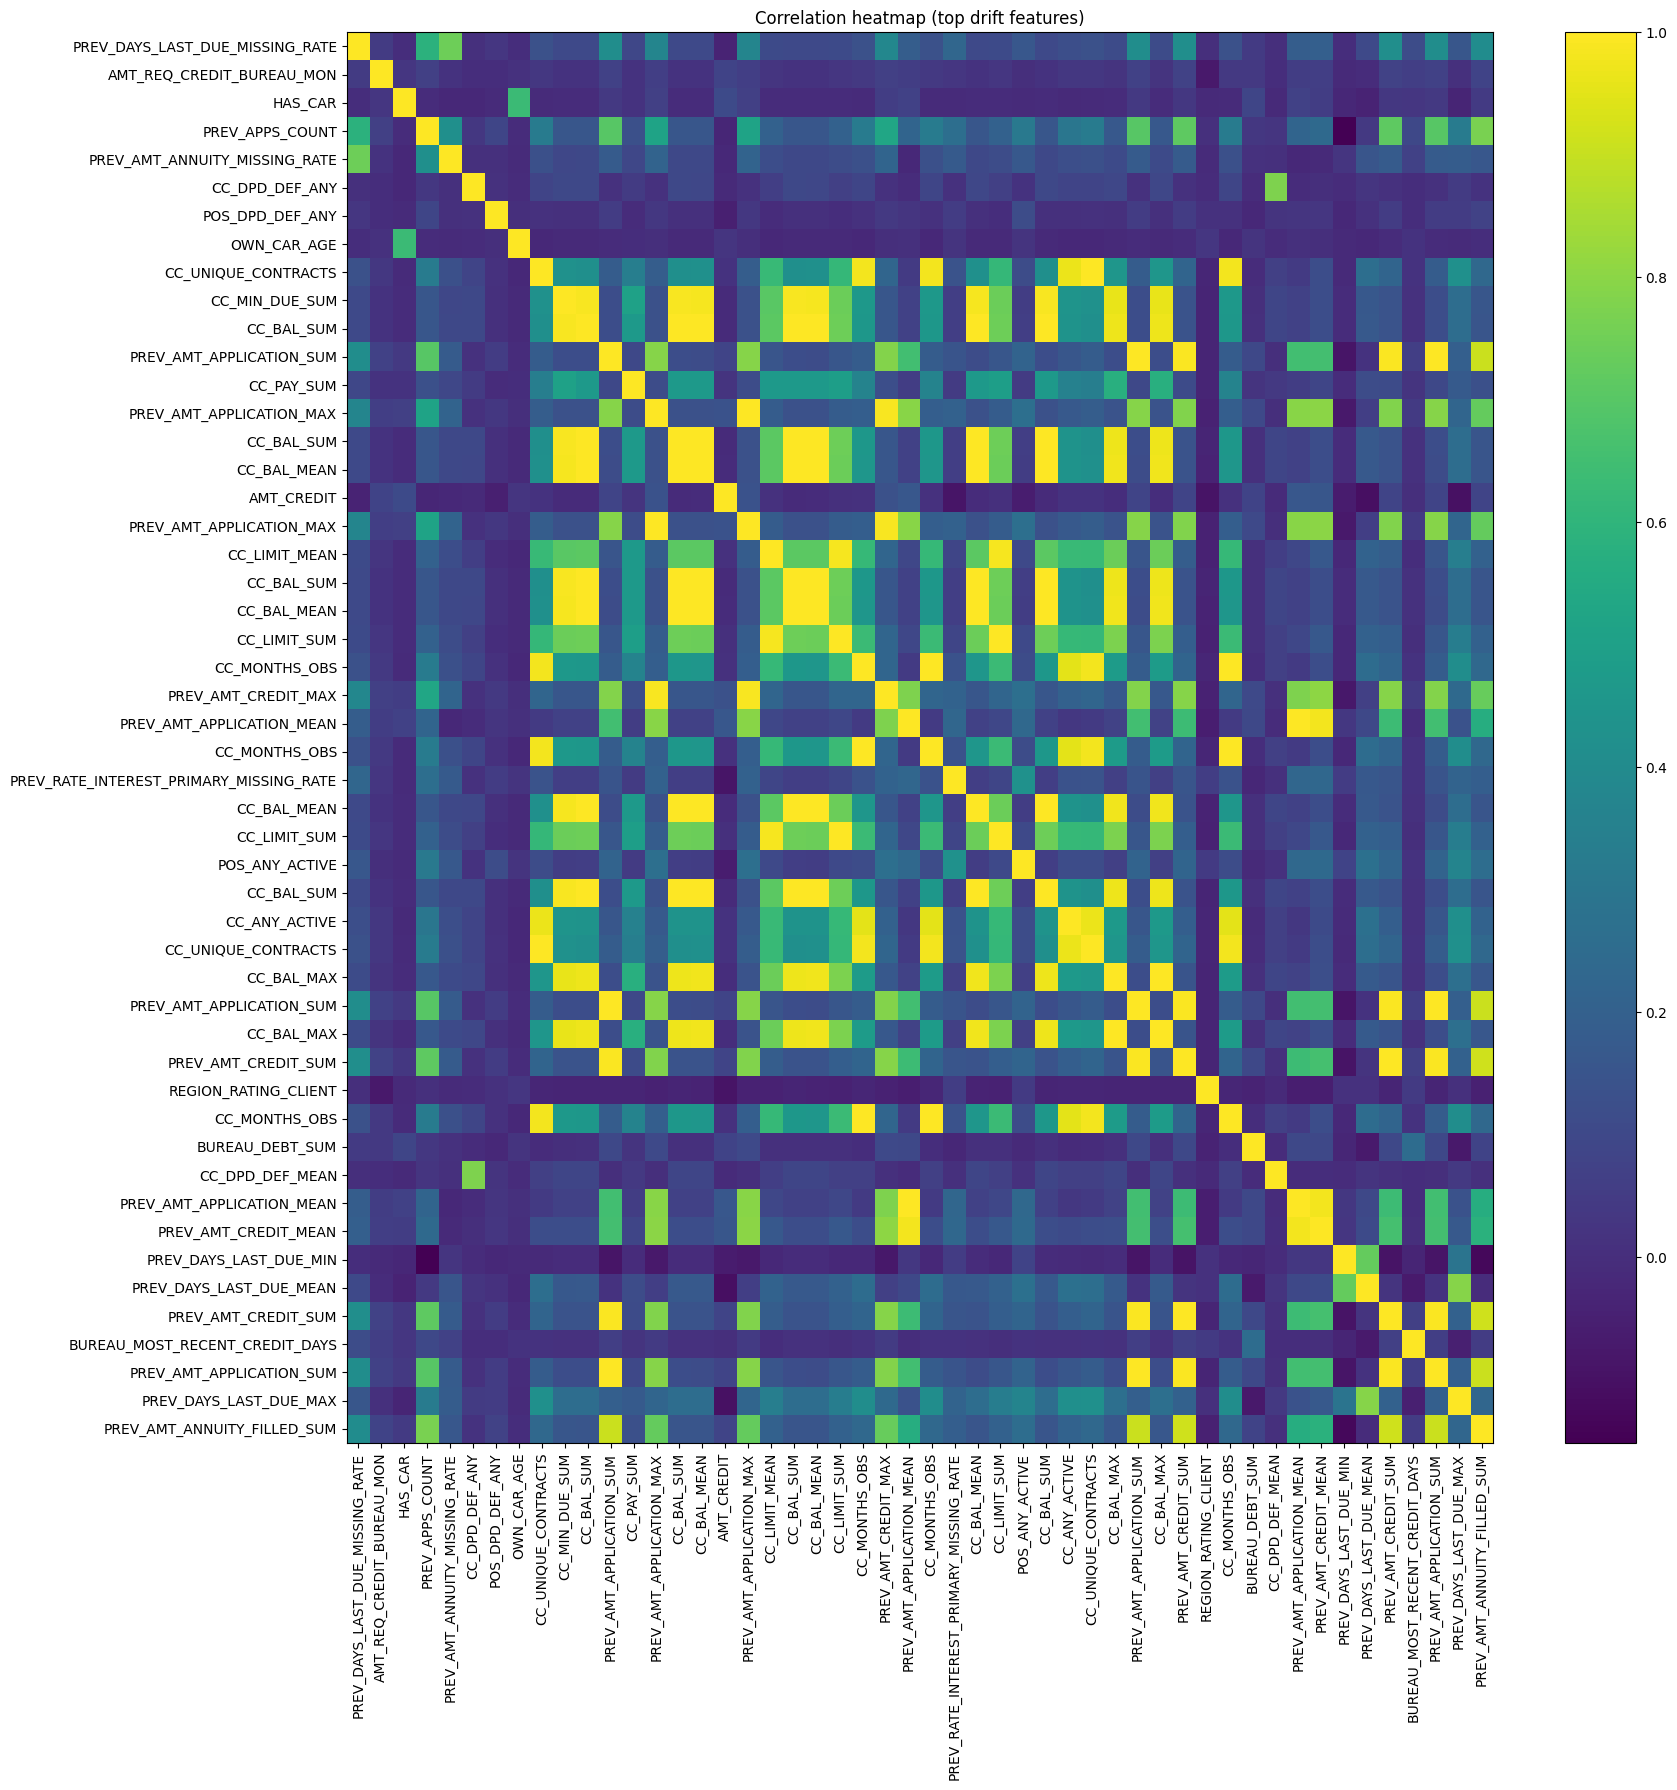

In [188]:
# pick a small set, e.g. top drifted features:
top_feats = corr_pairs["f1"].head(50).tolist()
corr_heatmap(merged_train, top_feats, "Correlation heatmap (top drift features)")


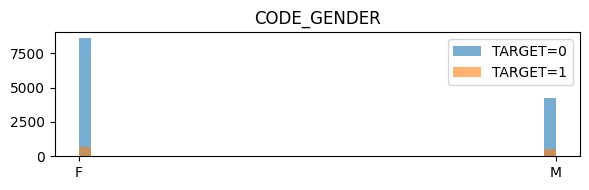

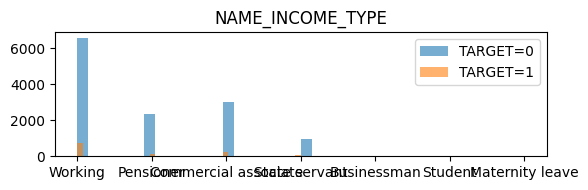

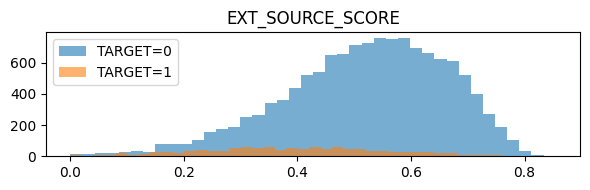

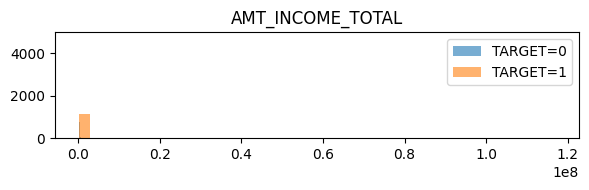

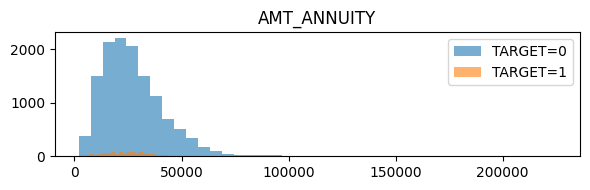

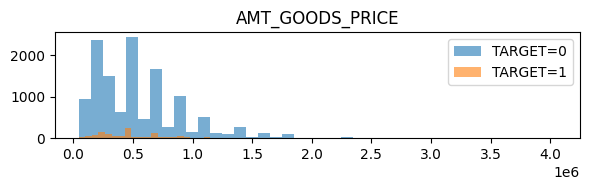

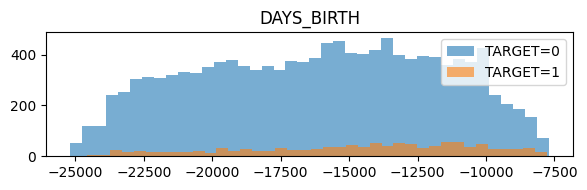

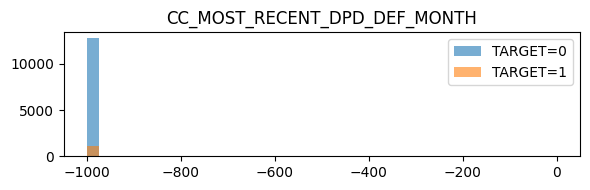

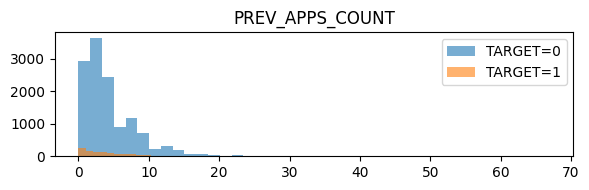

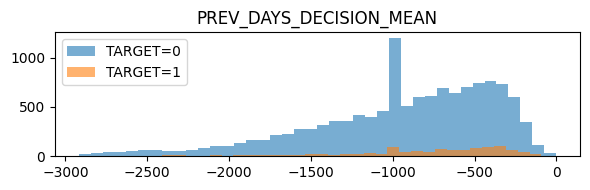

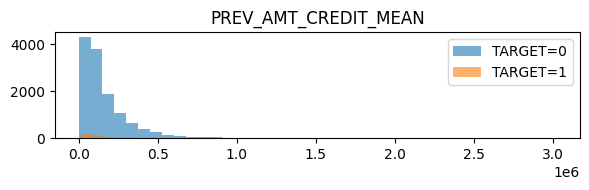

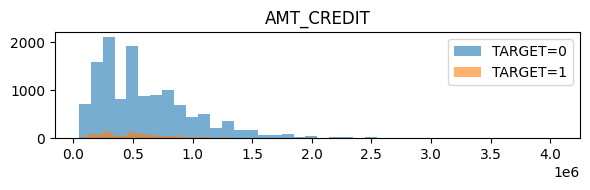

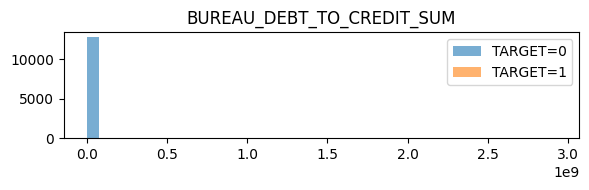

In [189]:
for f in ["CODE_GENDER","NAME_INCOME_TYPE","EXT_SOURCE_SCORE","AMT_INCOME_TOTAL","AMT_ANNUITY","AMT_GOODS_PRICE","DAYS_BIRTH","CC_MOST_RECENT_DPD_DEF_MONTH","PREV_APPS_COUNT","PREV_DAYS_DECISION_MEAN","PREV_AMT_CREDIT_MEAN","AMT_CREDIT","CREDIT_TO_INCOME","BUREAU_DEBT_TO_CREDIT_SUM"]:
    if f in merged_train.columns:
        plot_feature_by_target(merged_train, f)


## Analysis insights

1. high correlation amonst many columns - we will take care of that in feature eng.
2. Distribution of features don't tell me too much, since we can not investigate on scale. 
  - If I have time, I would maybe write a function to check if distributions are not normal and if there are differences between targets

In [190]:
merged_train.to_csv("../data/wrangled_data/merged_train.csv", index=False)
merged_val.to_csv("../data/wrangled_data/merged_val.csv", index=False)
merged_test.to_csv("../data/wrangled_data/merged_test.csv", index=False)